<a href="https://colab.research.google.com/github/Nachos-mic/Rotten_Review_Model/blob/main/EDT_Rotten_Review_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Review Analysis Pipeline
IMDB Sentiment Model + Rotten Tomatoes Fake/Biased Review Detection


TRENING MODELU 1 - IMDB SENTYMENT

In [1]:
!pip install contractions -qq
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [2]:
# ========================================
# IMPORTS & SETUP
# ========================================
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import contractions
from bs4 import BeautifulSoup
import kagglehub
import os

# NLTK downloads
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
# ========================================
# PART 1: IMDB SENTIMENT MODEL
# ========================================
print("="*60)
print("PART 1: TRAINING IMDB SENTIMENT MODEL")
print("="*60)

# Text Cleaning Functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def expand_contractions(text):
    return contractions.fix(text)

def to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

def clean_text(text):
    """IMDB cleaning pipeline"""
    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

PART 1: TRAINING IMDB SENTIMENT MODEL


In [4]:
# Load IMDB Dataset
print("\n📥 Loading IMDB dataset...")
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path = os.path.join(dataset_path, "IMDB Dataset.csv")
df_imdb = pd.read_csv(csv_path)

print(f"✅ Loaded {len(df_imdb)} IMDB reviews")
print(f"Sentiment distribution:\n{df_imdb['sentiment'].value_counts()}")


📥 Loading IMDB dataset...


100%|██████████| 25.7M/25.7M [00:01<00:00, 15.6MB/s]

Extracting files...


✅ Loaded 50000 IMDB reviews
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
# Clean and prepare
df_imdb['review'] = df_imdb['review'].apply(clean_text)
label_mapping = {'positive': 1, 'negative': -1}
df_imdb['sentiment_num'] = df_imdb['sentiment'].map(label_mapping)

In [6]:
# Display basic information
print(f"\n📊 Dataset Shape: {df_imdb.shape}")
print(f"📝 Columns: {df_imdb.columns.tolist()}")
print(f"\n🎬 Dataset Preview:")
df_imdb.head()


📊 Dataset Shape: (50000, 3)
📝 Columns: ['review', 'sentiment', 'sentiment_num']

🎬 Dataset Preview:


,review,sentiment,sentiment_num
0,one reviewer mentioned watching episode hooked...,positive,1
1,wonderful little production filming technique ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically family little boy jake think zombie ...,negative,-1
4,petter mattei love time money visually stunnin...,positive,1


In [7]:
# Check for missing values and basic statistics
print("🔍 Dataset Information:")
print("="*50)
print(f"Total reviews: {len(df_imdb)}")
print(f"Missing values: {df_imdb.isnull().sum().sum()}")
print(f"\nSentiment Distribution:")
print(df_imdb['sentiment'].value_counts())
print("\n📏 Review Length Statistics:")
df_imdb['review_length'] = df_imdb['review'].str.len()
print(f"Average length: {df_imdb['review_length'].mean():.0f} characters")
print(f"Shortest review: {df_imdb['review_length'].min()} characters")
print(f"Longest review: {df_imdb['review_length'].max()} characters")

🔍 Dataset Information:
Total reviews: 50000
Missing values: 0

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

📏 Review Length Statistics:
Average length: 797 characters
Shortest review: 17 characters
Longest review: 9038 characters


In [8]:
# Train sentiment model
print("\n🤖 Training Logistic Regression model...")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_imdb['review'])
y = df_imdb['sentiment_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


🤖 Training Logistic Regression model...


LogisticRegression(max_iter=1000)

In [9]:
y_pred = model.predict(X_test)
print(f"\n✅ Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


✅ Model Accuracy: 0.8827

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.88      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [10]:
def predict_sentiment(review_text):
    """Predict sentiment: 1 (positive) or -1 (negative)"""
    cleaned = clean_text(review_text)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

In [11]:
# ========================================
# PART 1: IMDB SENTIMENT MODEL
# ========================================
print("="*60)
print("PART 1: TRAINING IMDB SENTIMENT MODEL")
print("="*60)

# Text Cleaning Functions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def expand_contractions(text):
    return contractions.fix(text)

def to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    return " ".join(tokens)

def clean_text(text):
    """Universal cleaning pipeline - handles NaN and empty values"""
    # Obsługa NaN, None i pustych wartości
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = expand_contractions(text)
    text = to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

PART 1: TRAINING IMDB SENTIMENT MODEL


In [12]:
# ========================================
# PART 1: LOAD & PREPARE IMDB DATASET
# ========================================
print("="*60)
print("PART 1: LOADING IMDB DATASET")
print("="*60)

print("\n📥 Loading IMDB dataset...")
dataset_path_imdb = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path_imdb = os.path.join(dataset_path_imdb, "IMDB Dataset.csv")
df_imdb = pd.read_csv(csv_path_imdb)

print(f"✅ Loaded {len(df_imdb)} IMDB reviews")
print(f"Sentiment distribution:\n{df_imdb['sentiment'].value_counts()}")

# Przygotowanie IMDb
print("\n🧹 Cleaning IMDB reviews...")
df_imdb['review_cleaned'] = df_imdb['review'].apply(clean_text)
df_imdb['sentiment_label'] = df_imdb['sentiment'].map({'positive': 1, 'negative': -1})

# Usuń wiersze z pustym tekstem po czyszczeniu
df_imdb = df_imdb[df_imdb['review_cleaned'].str.strip() != ''].copy()

# Wybierz tylko potrzebne kolumny
df_imdb_final = df_imdb[['review_cleaned', 'sentiment_label']].copy()
df_imdb_final = df_imdb_final.rename(columns={'review_cleaned': 'text', 'sentiment_label': 'label'})
df_imdb_final['source'] = 'IMDB'

print(f"\n✅ IMDB prepared: {df_imdb_final.shape}")
print(f"Label distribution:")
print(df_imdb_final['label'].value_counts())
print(f"Positive (1): {(df_imdb_final['label'] == 1).sum()} ({(df_imdb_final['label'] == 1).sum()/len(df_imdb_final)*100:.1f}%)")
print(f"Negative (-1): {(df_imdb_final['label'] == -1).sum()} ({(df_imdb_final['label'] == -1).sum()/len(df_imdb_final)*100:.1f}%)")

PART 1: LOADING IMDB DATASET

📥 Loading IMDB dataset...
Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
✅ Loaded 50000 IMDB reviews
Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

🧹 Cleaning IMDB reviews...

✅ IMDB prepared: (50000, 3)
Label distribution:
label
 1    25000
-1    25000
Name: count, dtype: int64
Positive (1): 25000 (50.0%)
Negative (-1): 25000 (50.0%)


In [13]:
# ========================================
# PART 2: LOAD & PREPARE CLAPPER ROTTEN TOMATOES
# ========================================
print("\n" + "="*60)
print("PART 2: LOADING CLAPPER ROTTEN TOMATOES DATASET")
print("="*60)

print("\n📥 Downloading Clapper Rotten Tomatoes dataset...")
dataset_path_clapper = kagglehub.dataset_download(
    "andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews"
)

# Znajdź plik z recenzjami
import glob
csv_files = glob.glob(os.path.join(dataset_path_clapper, "*.csv"))
print(f"Found CSV files: {[os.path.basename(f) for f in csv_files]}")

# Szukaj pliku z recenzjami
reviews_file = None
for f in csv_files:
    fname = os.path.basename(f).lower()
    if 'review' in fname and 'movie' not in fname:
        reviews_file = f
        break
    elif 'movie_review' in fname:
        reviews_file = f
        break

if not reviews_file and csv_files:
    for f in csv_files:
        if 'review' in os.path.basename(f).lower():
            reviews_file = f
            break
    if not reviews_file:
        reviews_file = csv_files[0]

print(f"Using file: {os.path.basename(reviews_file)}")
df_clapper = pd.read_csv(reviews_file)

print(f"✅ Loaded {len(df_clapper)} Clapper RT reviews")
print(f"\n📋 Available columns: {df_clapper.columns.tolist()}")

# ========================================
# FILTROWANIE TOP CRITICS ONLY
# ========================================
print("\n" + "="*60)
print("FILTERING TOP CRITICS ONLY")
print("="*60)

# Znajdź kolumnę z top critic
top_critic_col = None
for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')
    if 'topcritic' in col_lower or 'istopdcritic' in col_lower:
        top_critic_col = col
        break

if top_critic_col:
    print(f"\n🔍 Found top critic column: '{top_critic_col}'")
    print(f"\nTop Critic distribution BEFORE filtering:")
    print(df_clapper[top_critic_col].value_counts(dropna=False))

    original_count = len(df_clapper)

    # Filtruj tylko top critics
    df_clapper = df_clapper[
        (df_clapper[top_critic_col] == True) |
        (df_clapper[top_critic_col] == 1) |
        (df_clapper[top_critic_col] == 'True') |
        (df_clapper[top_critic_col] == 'true')
    ].copy()

    filtered_count = len(df_clapper)
    print(f"\n✂️  Filtered from {original_count:,} to {filtered_count:,} reviews")
    print(f"   Kept {filtered_count/original_count*100:.1f}% of data (top critics only)")
else:
    print("\n⚠️  WARNING: Top critic column not found!")
    print(f"   Available columns: {df_clapper.columns.tolist()}")
    print("   Proceeding with ALL critics...")

# ========================================
# WYKRYWANIE I USUWANIE scoreSentiment
# ========================================
print("\n" + "="*60)
print("DETECTING AND REMOVING scoreSentiment COLUMN")
print("="*60)

# Znajdź kolumny
text_col = None
label_col = None
score_sentiment_col = None

for col in df_clapper.columns:
    col_lower = col.lower().replace('_', '').replace(' ', '')

    # Tekst recenzji
    if any(x in col_lower for x in ['reviewtext', 'text', 'content']):
        if text_col is None:
            text_col = col

    # Etykieta (reviewState, review_type)
    if any(x in col_lower for x in ['reviewstate', 'state', 'type']):
        if 'score' not in col_lower:
            label_col = col

    # scoreSentiment
    if 'scoresentiment' in col_lower or 'score' in col_lower and 'sentiment' in col_lower:
        score_sentiment_col = col

print(f"\n🔍 Detected columns:")
print(f"   Text column: {text_col}")
print(f"   Label column: {label_col}")
print(f"   ScoreSentiment column: {score_sentiment_col}")

# USUŃ scoreSentiment
if score_sentiment_col:
    print(f"\n🗑️  Removing '{score_sentiment_col}' (redundant with '{label_col}')")
    df_clapper = df_clapper.drop(columns=[score_sentiment_col])
    print(f"✅ Column '{score_sentiment_col}' removed")
else:
    print(f"\n⚠️  Column 'scoreSentiment' not found - skipping removal")

# Sprawdź czy znaleźliśmy wymagane kolumny
if text_col is None or label_col is None:
    print("\n❌ ERROR: Required columns not found!")
    print(f"Available columns: {df_clapper.columns.tolist()}")
    raise ValueError("Cannot proceed without text and label columns")

# ========================================
# CZYSZCZENIE TEKSTU
# ========================================
print(f"\n🧹 Cleaning Clapper RT reviews...")
print(f"   Original size: {len(df_clapper)}")

# KROK 1: Usuń wiersze z NaN w kolumnie tekstowej
df_clapper = df_clapper[df_clapper[text_col].notna()].copy()
print(f"   After removing NaN in '{text_col}': {len(df_clapper)}")

# KROK 2: Czyść tekst
df_clapper['text_cleaned'] = df_clapper[text_col].apply(clean_text)

# KROK 3: Usuń wiersze gdzie czyszczenie zwróciło pusty string
df_clapper = df_clapper[df_clapper['text_cleaned'].str.strip() != ''].copy()
print(f"   After cleaning and removing empty: {len(df_clapper)}")

# ========================================
# MAPOWANIE ETYKIET
# ========================================
print(f"\n📊 Unique values in '{label_col}':")
print(df_clapper[label_col].value_counts())

# Mapowanie na 1/-1 (zgodnie z IMDB)
def map_rt_sentiment(val):
    if pd.isna(val):
        return None
    val_str = str(val).lower().strip()
    # Fresh/Positive = 1, Rotten/Negative = -1
    if val_str in ['fresh', 'positive', '1', 'pos']:
        return 1
    elif val_str in ['rotten', 'negative', '0', 'neg']:
        return -1
    else:
        return None

df_clapper['sentiment_label'] = df_clapper[label_col].apply(map_rt_sentiment)

# Diagnostyka
print(f"\n🔍 DIAGNOSTIC - After mapping:")
print(f"Mapped label distribution:")
print(df_clapper['sentiment_label'].value_counts(dropna=False))
print(f"NaN values: {df_clapper['sentiment_label'].isna().sum()}")

# Usuń wiersze z brakującymi etykietami
original_count = len(df_clapper)
df_clapper = df_clapper.dropna(subset=['sentiment_label']).copy()
print(f"\n✂️  Filtered from {original_count} to {len(df_clapper)} reviews with valid labels")

# Finalne przygotowanie
df_clapper_final = df_clapper[['text_cleaned', 'sentiment_label']].copy()
df_clapper_final = df_clapper_final.rename(columns={'text_cleaned': 'text', 'sentiment_label': 'label'})
df_clapper_final['label'] = df_clapper_final['label'].astype(int)
df_clapper_final['source'] = 'Clapper_RT'

print(f"\n✅ Clapper RT prepared: {df_clapper_final.shape}")
print(f"Label distribution:")
print(df_clapper_final['label'].value_counts())
print(f"Positive (1): {(df_clapper_final['label'] == 1).sum()} ({(df_clapper_final['label'] == 1).sum()/len(df_clapper_final)*100:.1f}%)")
print(f"Negative (-1): {(df_clapper_final['label'] == -1).sum()} ({(df_clapper_final['label'] == -1).sum()/len(df_clapper_final)*100:.1f}%)")



PART 2: LOADING CLAPPER ROTTEN TOMATOES DATASET

📥 Downloading Clapper Rotten Tomatoes dataset...


100%|██████████| 152M/152M [00:06<00:00, 24.2MB/s]

Extracting files...


Found CSV files: ['rotten_tomatoes_movies.csv', 'rotten_tomatoes_movie_reviews.csv']
Using file: rotten_tomatoes_movie_reviews.csv
✅ Loaded 1444963 Clapper RT reviews

📋 Available columns: ['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic', 'originalScore', 'reviewState', 'publicatioName', 'reviewText', 'scoreSentiment', 'reviewUrl']

FILTERING TOP CRITICS ONLY

🔍 Found top critic column: 'isTopCritic'

Top Critic distribution BEFORE filtering:
isTopCritic
False    1008156
True      436807
Name: count, dtype: int64

✂️  Filtered from 1,444,963 to 436,807 reviews
   Kept 30.2% of data (top critics only)

DETECTING AND REMOVING scoreSentiment COLUMN

🔍 Detected columns:
   Text column: reviewText
   Label column: reviewState
   ScoreSentiment column: scoreSentiment

🗑️  Removing 'scoreSentiment' (redundant with 'reviewState')
✅ Column 'scoreSentiment' removed

🧹 Cleaning Clapper RT reviews...
   Original size: 436807
   After removing NaN in 'reviewText': 426300
   After clea

In [14]:
# ========================================
# PART 3: COMBINE IMDB + CLAPPER DATASETS
# ========================================
print("\n" + "="*60)
print("PART 3: COMBINING DATASETS")
print("="*60)

# Połącz oba datasety
df_combined = pd.concat([df_imdb_final, df_clapper_final], ignore_index=True)

print(f"\n✅ Combined dataset: {df_combined.shape}")
print(f"\n📊 Source distribution:")
print(df_combined['source'].value_counts())
print(f"\n📊 Label distribution:")
print(df_combined['label'].value_counts())

# Usuń duplikaty tekstowe
print(f"\n🔄 Removing duplicate reviews...")
original_size = len(df_combined)
df_combined = df_combined.drop_duplicates(subset=['text'], keep='first')
duplicates_removed = original_size - len(df_combined)
print(f"Removed {duplicates_removed} duplicates ({duplicates_removed/original_size*100:.1f}%)")

# Losowe przemieszanie
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Final combined dataset: {df_combined.shape}")
print(f"   IMDB: {(df_combined['source'] == 'IMDB').sum()}")
print(f"   Clapper RT: {(df_combined['source'] == 'Clapper_RT').sum()}")



PART 3: COMBINING DATASETS

✅ Combined dataset: (476268, 3)

📊 Source distribution:
source
Clapper_RT    426268
IMDB           50000
Name: count, dtype: int64

📊 Label distribution:
label
 1    294728
-1    181540
Name: count, dtype: int64

🔄 Removing duplicate reviews...
Removed 5391 duplicates (1.1%)

✅ Final combined dataset: (470877, 3)
   IMDB: 49574
   Clapper RT: 421303



PART 4: TRAINING MODEL ON COMBINED DATASET

🤖 Vectorizing text...
Feature matrix shape: (470877, 10000)
Vocabulary size: 10000

📊 Data split:
   Training: 376701 reviews
   Testing: 94176 reviews
   Train label dist: {1: 233106, -1: 143595}

🚀 Training Logistic Regression...
✅ Training complete

📈 Evaluating model...

✅ MODEL PERFORMANCE:
   Train Accuracy: 0.8174
   Test Accuracy:  0.8016

📊 Classification Report (Test Set):
               precision    recall  f1-score   support

Negative (-1)       0.77      0.68      0.72     35899
 Positive (1)       0.82      0.87      0.85     58277

     accuracy                           0.80     94176
    macro avg       0.79      0.78      0.78     94176
 weighted avg       0.80      0.80      0.80     94176



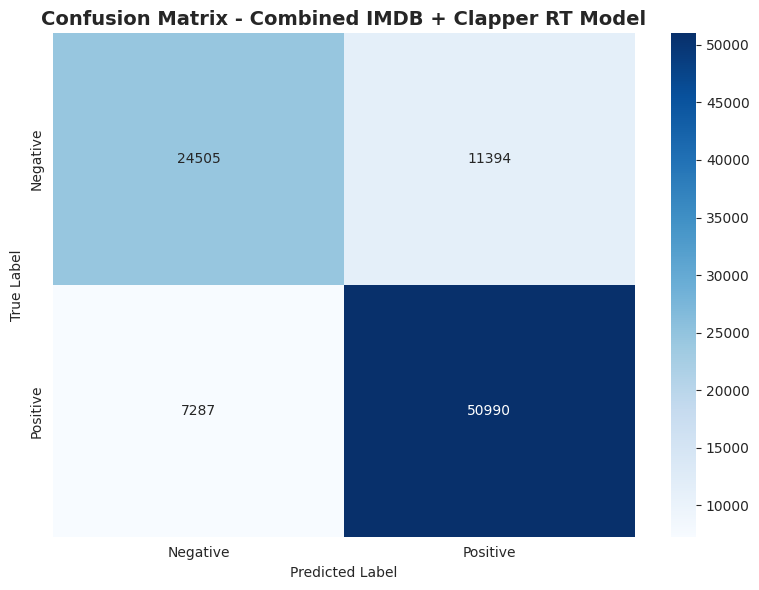


🎬 TEST PREDICTIONS

1. This movie was absolutely amazing! Best film I've seen this year....
   → POSITIVE ✓

2. Terrible waste of time. The acting was awful and the plot made no sense....
   → NEGATIVE ✗

3. Pretty good overall, had some great moments despite a few flaws....
   → POSITIVE ✓


In [15]:
# ========================================
# PART 4: TRAIN SENTIMENT MODEL ON COMBINED DATA
# ========================================
print("\n" + "="*60)
print("PART 4: TRAINING MODEL ON COMBINED DATASET")
print("="*60)

print("\n🤖 Vectorizing text...")
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
X = vectorizer.fit_transform(df_combined['text'])
y = df_combined['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Podział train/test ze stratyfikacją
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data split:")
print(f"   Training: {X_train.shape[0]} reviews")
print(f"   Testing: {X_test.shape[0]} reviews")
print(f"   Train label dist: {pd.Series(y_train).value_counts().to_dict()}")

# Trenowanie
print("\n🚀 Training Logistic Regression...")
model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
model.fit(X_train, y_train)
print("✅ Training complete")

# Ewaluacja
print("\n📈 Evaluating model...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\n✅ MODEL PERFORMANCE:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred_test,
                          target_names=['Negative (-1)', 'Positive (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Combined IMDB + Clapper RT Model',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Funkcja predykcji
def predict_sentiment(review_text):
    """
    Predict sentiment for a review.
    Returns: 1 (positive) or 0 (negative)
    """
    cleaned = clean_text(review_text)
    if not cleaned.strip():
        return None
    vector = vectorizer.transform([cleaned])
    return int(model.predict(vector)[0])

# Test prediction
test_reviews = [
    "This movie was absolutely amazing! Best film I've seen this year.",
    "Terrible waste of time. The acting was awful and the plot made no sense.",
    "Pretty good overall, had some great moments despite a few flaws."
]

print("\n" + "="*60)
print("🎬 TEST PREDICTIONS")
print("="*60)
for i, review in enumerate(test_reviews, 1):
    pred = predict_sentiment(review)
    sentiment = 'POSITIVE ✓' if pred == 1 else 'NEGATIVE ✗'
    print(f"\n{i}. {review[:80]}...")
    print(f"   → {sentiment}")


In [16]:
y_pred = model.predict(X_test)
print(f"\n✅ Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


✅ Model Accuracy: 0.8016

Classification Report:
              precision    recall  f1-score   support

          -1       0.77      0.68      0.72     35899
           1       0.82      0.87      0.85     58277

    accuracy                           0.80     94176
   macro avg       0.79      0.78      0.78     94176
weighted avg       0.80      0.80      0.80     94176



In [17]:
def predict_sentiment(review_text):
    """Predict sentiment: 1 (positive) or -1 (negative)"""
    cleaned = clean_text(review_text)
    vector = vectorizer.transform([cleaned])
    return model.predict(vector)[0]

# MODEL 2 - BIAS ROTTEN TOMATOES

EDA & PREPROCESSING

In [18]:
# ========================================
# PART 2: ROTTEN TOMATOES DATA LOADING
# ========================================
print("\n" + "="*60)
print("PART 2: LOADING ROTTEN TOMATOES DATA")
print("="*60)

dataset_path_rt = kagglehub.dataset_download(
    "stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset"
)

movies_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_movies.csv")
reviews_csv = os.path.join(dataset_path_rt, "rotten_tomatoes_critic_reviews.csv")

movies_df = pd.read_csv(movies_csv)
reviews_df = pd.read_csv(reviews_csv)

print(f"\n📊 Movies: {movies_df.shape}")
print(f"📊 Reviews: {reviews_df.shape}")


PART 2: LOADING ROTTEN TOMATOES DATA


100%|██████████| 77.2M/77.2M [00:03<00:00, 21.3MB/s]

Extracting files...



📊 Movies: (17712, 22)
📊 Reviews: (1130017, 8)


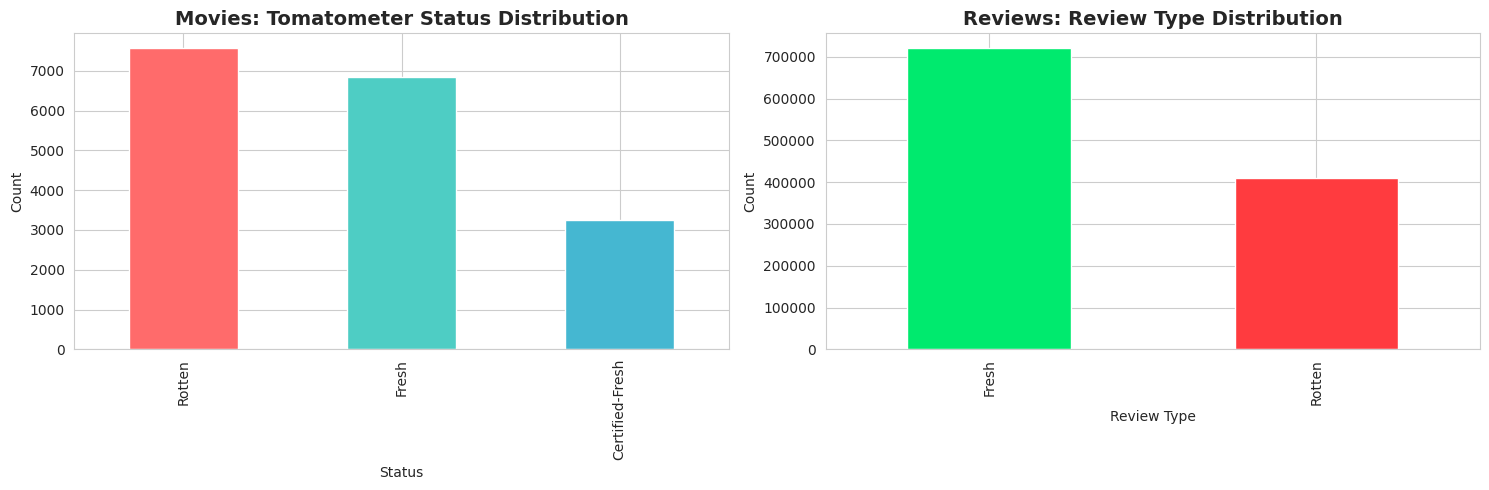

In [19]:
# Analiza rozkładu sentiment/review_type
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if 'tomatometer_status' in movies_df.columns:
    movies_df['tomatometer_status'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_title('Movies: Tomatometer Status Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Status')
    axes[0].set_ylabel('Count')

if 'review_type' in reviews_df.columns:
    reviews_df['review_type'].value_counts().plot(kind='bar', ax=axes[1], color=['#00EA6E', '#FF3B3F'])
    axes[1].set_title('Reviews: Review Type Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Review Type')
    axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', '3.5/4', 'A', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '87/100', '74/100', '86/100', '81/100', '56/100',
       '78/100', '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5',
       '8.6/10', '79/100', '68/100', '80/100', '90/100', '66/100',
       '91/100', '0.3/5', '9.2/10', '2.7/5', '57/100', '4/6', '3/6',
       '73/100', '42/100', '65/100', '7.5/10', '4.5/10', '5/6', '1/6',
       '70/100', '3.5/10', '71/100', '0.1/5', '3.25/10', '89/100',
       '40/100', '64/100', '62/100', '1/10', '3.75/5', '37/100', '49/100',
       '60/100', '3.3/5', '77/100', '5.25/10', '1.4/4', '75/100', '1.5/6

In [21]:
# ========================================
# EDA 1: Initial Data Exploration
# ========================================
print("\n" + "="*60)
print("EDA 1: INITIAL DATA QUALITY CHECK")
print("="*60)

print("\n🔍 Reviews Dataset:")
print(f"  Total reviews: {len(reviews_df)}")
print(f"  Missing values:\n{reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0]}")
print(f"\n  Top Critic Distribution:")
print(reviews_df['top_critic'].value_counts(dropna=False))

print("\n🔍 Movies Dataset:")
print(f"  Total movies: {len(movies_df)}")
# Convert 'original_release_date' to datetime, coercing errors
movies_df['original_release_date'] = pd.to_datetime(movies_df['original_release_date'], errors='coerce')
print(f"  Date range: {movies_df['original_release_date'].min()} to {movies_df['original_release_date'].max()}")


EDA 1: INITIAL DATA QUALITY CHECK

🔍 Reviews Dataset:
  Total reviews: 1130017
  Missing values:
critic_name        18529
review_score      305936
review_content     65806
dtype: int64

  Top Critic Distribution:
top_critic
False    841481
True     288536
Name: count, dtype: int64

🔍 Movies Dataset:
  Total movies: 17712
  Date range: 1914-06-01 00:00:00 to 2020-09-30 00:00:00


In [22]:
# ========================================
# PREPROCESSING 1: Filter Top Critics Only
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 1: FILTERING TOP CRITICS")
print("="*60)

original_count = len(reviews_df)
reviews_df = reviews_df[reviews_df['top_critic'] == True].copy()
print(f"✂️ Filtered from {original_count} to {len(reviews_df)} reviews (top critics only)")
print(f"   Kept {len(reviews_df)/original_count*100:.1f}% of data")


PREPROCESSING 1: FILTERING TOP CRITICS
✂️ Filtered from 1130017 to 288536 reviews (top critics only)
   Kept 25.5% of data


In [23]:
reviews_df['review_score'].dropna().unique()


array(['3.5/5', '3/5', '2/4', '2/5', '3/4', 'C-', '2.5/4', 'C+', 'D+',
       '1/5', 'C', '4/5', 'A-', '4.5/5', '3.5/4', 'A', '1.5/4', '4/4',
       'B', '5/5', '1.5/5', '1/4', 'D', 'F', '2/6', 'B-', '0/4', 'B+',
       'D-', '2.5/5', '0.5/4', '0/5', '2.4/5', '4/6', '3/6', '5/10',
       '5/6', '1/6', '5.5/10', '7/10', '8/10', '6/10', '3/10', '8.5/10',
       '5.9/10', '4.6/10', '3.4/10', '10/10', '0.5/5', '35/100', '1/3',
       '42/100', '9/10', '55/100', '80/100', '78/100', '94/100', '5/100',
       '75/100', '50/100', '30/100', '62/100', '52/100', '3', '2/2',
       '4/10', '3.5/6', '7.5/10', '6.4/10', '4.5/10', '45/100', '70/100',
       '2.5/10', '68/100', '15/100', '0', '0.5/10', '2', '0/6', '0/10',
       '1/10', '8.3/10', '8.1/10', '3.5/10', '1.2/10', '5.2/10', '6.5/10',
       '6.2/10', '47/100', '4.2/10', '9.1/10', '20/100', '7.2/10',
       '40/100', '85/100', '5', '10/100', '90/100', '4.8/10', '41/100',
       '6.8/10', '6.6/10', '5.3/10', '3/3', '8.6/10', '6.3/10', '8.7/1

tu trzeba zrobić rzutowanie na liczby całkowite od 0/1 do 100

In [24]:
# ========================================
# PREPROCESSING 2: Merge Datasets
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 2: MERGING REVIEWS WITH MOVIES")
print("="*60)

# Select relevant movie columns
movie_cols = ['rotten_tomatoes_link', 'original_release_date', 'tomatometer_rating',
              'tomatometer_status', 'audience_rating', 'audience_status', 'movie_title']
movies_subset = movies_df[movie_cols].copy()

# Merge
df = reviews_df.merge(movies_subset, on='rotten_tomatoes_link', how='left')
print(f"✅ Merged dataset: {df.shape}")
print(f"   Merge success rate: {(1 - df['original_release_date'].isna().sum()/len(df))*100:.1f}%")


PREPROCESSING 2: MERGING REVIEWS WITH MOVIES
✅ Merged dataset: (288536, 14)
   Merge success rate: 98.2%


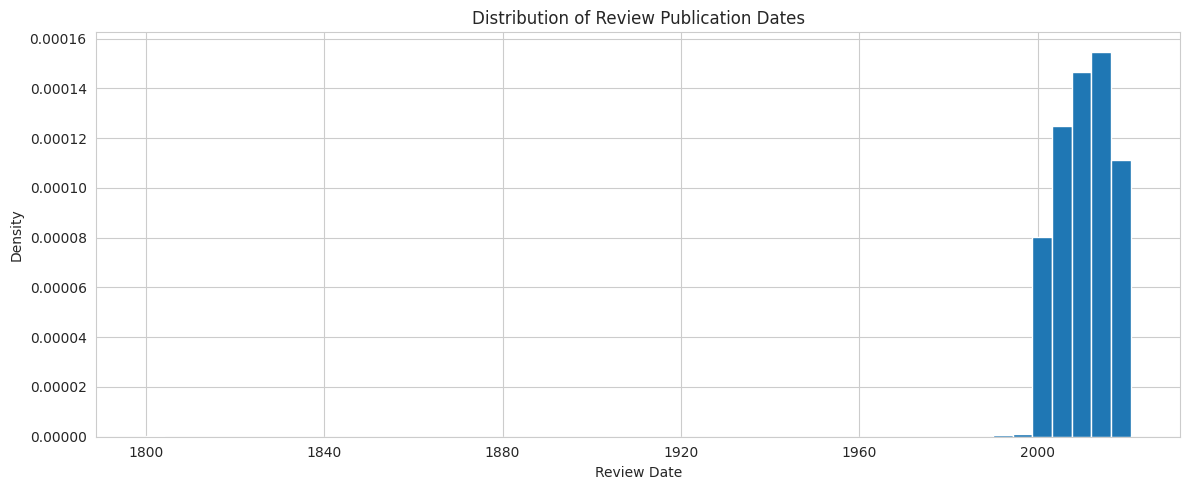

In [25]:
df['review_date'] = pd.to_datetime(df['review_date'])

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.hist(
    df['review_date'],
    bins=50,
    density=True
)

plt.xlabel("Review Date")
plt.ylabel("Density")
plt.title("Distribution of Review Publication Dates")

plt.tight_layout()
plt.show()


In [26]:
# ========================================
# EDA 2: Text Quality Analysis
# ========================================
print("\n" + "="*60)
print("EDA 2: TEXT CONTENT ANALYSIS")
print("="*60)

# Sample reviews to check for artifacts
sample_reviews = df['review_content'].dropna().head(10)
print("\n📝 Sample review (first 200 chars):")
print(sample_reviews.iloc[0][:200])

# Check for HTML tags
html_pattern = re.compile('<.*?>')
has_html = df['review_content'].str.contains(html_pattern, na=False).sum()
print(f"\n🔍 Reviews with HTML tags: {has_html}")

# Check for URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')
has_urls = df['review_content'].str.contains(url_pattern, na=False).sum()
print(f"🔍 Reviews with URLs: {has_urls}")

# Text length distribution
df['review_length_raw'] = df['review_content'].str.len()
print(f"\n📏 Review length stats:")
print(df['review_length_raw'].describe())


EDA 2: TEXT CONTENT ANALYSIS

📝 Sample review (first 200 chars):
What's really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again.

🔍 Reviews with HTML tags: 0
🔍 Reviews with URLs: 12

📏 Review length stats:
count    280638.000000
mean        129.424044
std          55.675716
min           4.000000
25%          87.000000
50%         128.000000
75%         170.000000
max         257.000000
Name: review_length_raw, dtype: float64


In [27]:
# ========================================
# PREPROCESSING 3: Text Cleaning
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 3: CLEANING TEXT CONTENT")
print("="*60)

CHAT_WORDS = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

def remove_urls(text):
    if not isinstance(text, str):
        return ''
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    if not isinstance(text, str):
        return ''
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emotikony
        u"\U0001F300-\U0001F5FF"  # symbole i piktogramy
        u"\U0001F680-\U0001F6FF"  # transport i symbole map
        u"\U0001F1E0-\U0001F1FF"  # flagi (iOS)
        u"\U00002500-\U00002BEF"  # chińskie znaki/symbole
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"
        u"\U0001F926-\U0001F937"  # dodatkowe twarze i gesty
        u"\U00010000-\U0010ffff"  # dodatkowe symbole
        u"\U0001F900-\U0001F9FF"  # symbole emotikony (2017+)
        u"\U0001FA00-\U0001FA6F"  # symbole rozszerzone-A
        u"\U0001FA70-\U0001FAFF"  # symbole rozszerzone-B
        u"\u2640-\u2642"           # symbole płci
        u"\u2600-\u2B55"           # różne symbole
        u"\u200d"                  # zero width joiner
        u"\ufe0f"                  # variation selector
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)


def expand_chat_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    expanded = [CHAT_WORDS.get(word.upper(), word) for word in words]
    return ' '.join(expanded)

def remove_punctuation(text):
    if not isinstance(text, str):
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_text_rt(text):
    """Rotten Tomatoes cleaning pipeline"""
    if not isinstance(text, str) or not text.strip():
        return ''

    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_emoji(text)
    text = expand_chat_words(text)
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)

    return text

print("🧹 Cleaning review content...")
df['text_cleaned'] = df['review_content'].apply(clean_text_rt)

empty_after_cleaning = (df['text_cleaned'].str.strip() == '').sum()
print(f"✅ Cleaned {len(df)} reviews")
print(f"   Empty after cleaning: {empty_after_cleaning}")


PREPROCESSING 3: CLEANING TEXT CONTENT
🧹 Cleaning review content...
✅ Cleaned 288536 reviews
   Empty after cleaning: 7904


In [28]:
# ========================================
# EDA 3: Post-Cleaning Analysis
# ========================================
print("\n" + "="*60)
print("EDA 3: POST-CLEANING QUALITY CHECK")
print("="*60)

df['text_length_cleaned'] = df['text_cleaned'].str.len()
print("📏 Cleaned text length distribution:")
print(df['text_length_cleaned'].describe())

print("\n📝 Sample cleaned review:")
print(df['text_cleaned'].iloc[0][:200])


EDA 3: POST-CLEANING QUALITY CHECK
📏 Cleaned text length distribution:
count    288536.000000
mean        121.980980
std          57.411691
min           0.000000
25%          80.000000
50%         122.000000
75%         164.000000
max         275.000000
Name: text_length_cleaned, dtype: float64

📝 Sample cleaned review:
whats really lacking in the lightning thief is a genuine sense of wonder the same thing that brings viewers back to hogwarts over and over again


In [29]:
# ========================================
# PREPROCESSING 4: Tokenization & Lemmatization
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 4: TOKENIZATION & LEMMATIZATION")
print("="*60)

def get_wordnet_pos(treebank_tag):
    tag_dict = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return tag_dict.get(treebank_tag[0], wordnet.NOUN)

def tokenize_and_lemmatize(text, remove_stopwords=True, min_word_length=2):
    if not isinstance(text, str) or not text.strip():
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and len(word) >= min_word_length]

    if remove_stopwords:
        stop_words_set = set(stopwords.words('english'))
        custom_stopwords = {'film', 'movie', 'movies', 'films', 'scene', 'scenes'}
        stop_words_set.update(custom_stopwords)
        tokens = [word for word in tokens if word not in stop_words_set]

    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos))
                  for word, pos in pos_tags]

    return lemmatized

print("🔤 Tokenizing and lemmatizing...")
df['tokens'] = df['text_cleaned'].apply(tokenize_and_lemmatize)
df['token_count'] = df['tokens'].apply(len)
df['tokens_text'] = df['tokens'].apply(lambda x: ' '.join(x))

print(f"✅ Tokenization complete")
print(f"   Avg tokens per review: {df['token_count'].mean():.1f}")
print(f"   Median tokens: {df['token_count'].median():.0f}")


PREPROCESSING 4: TOKENIZATION & LEMMATIZATION
🔤 Tokenizing and lemmatizing...
✅ Tokenization complete
   Avg tokens per review: 11.5
   Median tokens: 11


In [30]:
# ========================================
# PREPROCESSING 5: Date Processing
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 5: DATE FEATURE EXTRACTION")
print("="*60)

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['original_release_date'] = pd.to_datetime(df['original_release_date'], errors='coerce')

df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['release_year'] = df['original_release_date'].dt.year

df['days_since_release'] = (df['review_date'] - df['original_release_date']).dt.days

print(f"✅ Date features extracted")
print(f"   Reviews with valid dates: {df['days_since_release'].notna().sum()}")
print(f"   Date range: {df['review_date'].min()} to {df['review_date'].max()}")


PREPROCESSING 5: DATE FEATURE EXTRACTION
✅ Date features extracted
   Reviews with valid dates: 283202
   Date range: 1800-01-01 00:00:00 to 2020-10-27 00:00:00


In [31]:
# ========================================
# EDA 4: Temporal Patterns
# ========================================
print("\n" + "="*60)
print("EDA 4: REVIEW TIMING ANALYSIS")
print("="*60)

early_reviews = (df['days_since_release'] < 7).sum()
print(f"🚨 Early reviews (< 7 days): {early_reviews} ({early_reviews/len(df)*100:.1f}%)")

print("\nDays since release distribution:")
print(df['days_since_release'].describe())


EDA 4: REVIEW TIMING ANALYSIS
🚨 Early reviews (< 7 days): 178789 (62.0%)

Days since release distribution:
count    283202.000000
mean       1075.730193
std        3806.020012
min      -77261.000000
25%          -1.000000
50%           0.000000
75%          49.000000
max       38854.000000
Name: days_since_release, dtype: float64


In [32]:
# ========================================
# EDA 4: Temporal Patterns
# ========================================
print("\n" + "="*60)
print("EDA 4: REVIEW TIMING ANALYSIS")
print("="*60)

early_reviews = (df['days_since_release'] < 7).sum()
print(f"🚨 Early reviews (< 7 days): {early_reviews} ({early_reviews/len(df)*100:.1f}%)")

print("\nDays since release distribution:")
print(df['days_since_release'].describe())


EDA 4: REVIEW TIMING ANALYSIS
🚨 Early reviews (< 7 days): 178789 (62.0%)

Days since release distribution:
count    283202.000000
mean       1075.730193
std        3806.020012
min      -77261.000000
25%          -1.000000
50%           0.000000
75%          49.000000
max       38854.000000
Name: days_since_release, dtype: float64


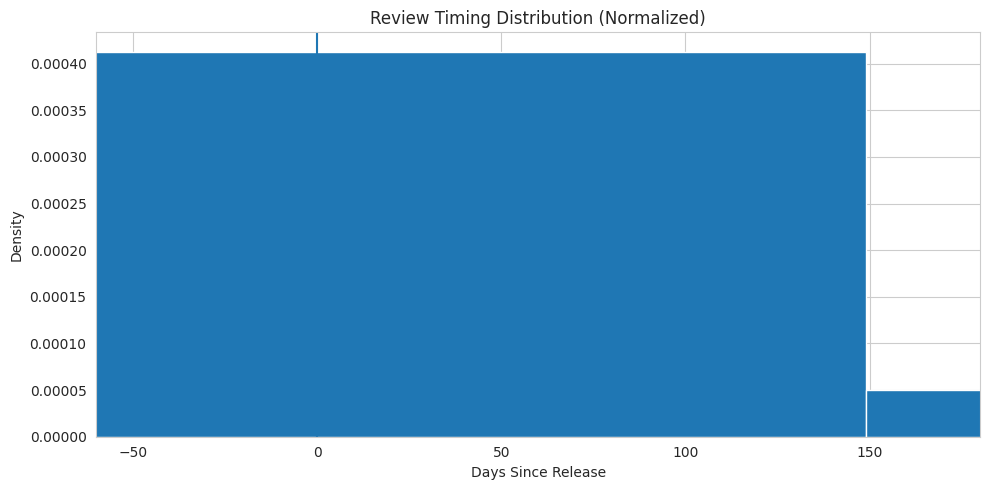

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

df['days_since_release'].plot.hist(
    bins=60,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Timing Distribution (Normalized)")

plt.xlim(-60, 180)  # zakres czytelny, bez długiego ogona
plt.tight_layout()
plt.show()


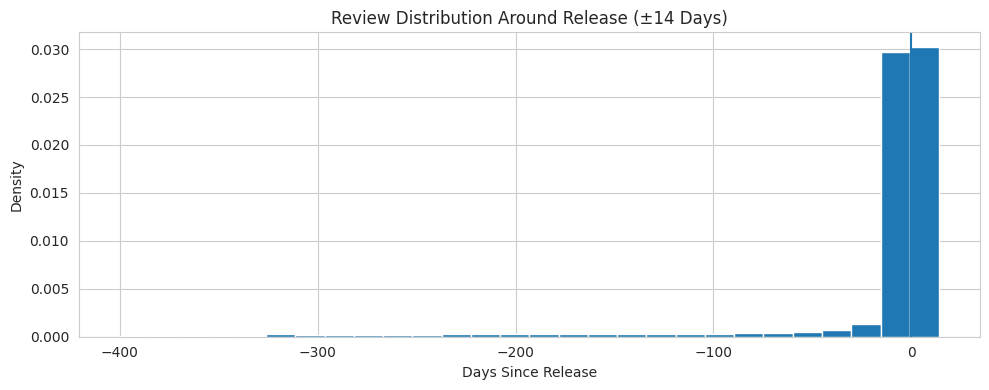

In [34]:
plt.figure(figsize=(10, 4))

df[
    (df['days_since_release'] >= -400) &
    (df['days_since_release'] <= 14)
]['days_since_release'].plot.hist(
    bins=28,
    density=True
)

plt.axvline(0)
plt.xlabel("Days Since Release")
plt.ylabel("Density")
plt.title("Review Distribution Around Release (±14 Days)")

plt.tight_layout()
plt.show()


In [35]:
df.sort_values('days_since_release').head(5)[
    ['movie_title', 'days_since_release', 'review_date', 'original_release_date']
]


,movie_title,days_since_release,review_date,original_release_date
102388,Gunless,-77261.0,1800-01-01,2011-07-15
48037,Black Death,-77135.0,1800-01-01,2011-03-11
105544,Heartless,-77023.0,1800-01-01,2010-11-19
276590,Wah Do Dem,-76869.0,1800-01-01,2010-06-18
276591,Wah Do Dem,-76869.0,1800-01-01,2010-06-18


In [36]:
# upewnij się, że daty są datetime
df['review_date'] = pd.to_datetime(df['review_date'])
df['original_release_date'] = pd.to_datetime(df['original_release_date'])

# znajdź najnowszy film (max release_date)
latest_release_date = df['original_release_date'].max()

# wszystkie recenzje tego filmu
latest_movie_reviews = df[df['original_release_date'] == latest_release_date]

# najstarsza recenzja dla tego filmu
oldest_review_latest_movie = latest_movie_reviews.sort_values('review_date').head(1)

oldest_review_latest_movie[
    ['movie_title', 'original_release_date', 'review_date', 'days_since_release']
]


,movie_title,original_release_date,review_date,days_since_release
17133,Billy the Kid,2020-09-30,2007-12-03,-4685.0


In [37]:
# ========================================
# PREPROCESSING 6: Feature Engineering
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 6: FEATURE ENGINEERING")
print("="*60)

# Categorical encoding
df['review_type_encoded'] = df['review_type'].map({'Fresh': 1, 'Rotten': 0})

# Text features
df['word_count'] = df['text_cleaned'].str.split().str.len()
df['sentence_count'] = df['text_cleaned'].str.count(r'[.!?]') + 1
df['avg_word_length'] = df['text_length_cleaned'] / df['word_count'].replace(0, 1)
df['unique_word_count'] = df['tokens'].apply(lambda x: len(set(x)))
df['lexical_diversity'] = df['unique_word_count'] / df['token_count'].replace(0, 1)

# Behavioral features
df['is_early_review'] = df['days_since_release'] < 7

print("✅ Feature engineering complete")
print(f"   Total features created: text (7) + temporal (5) + categorical (1)")


PREPROCESSING 6: FEATURE ENGINEERING
✅ Feature engineering complete
   Total features created: text (7) + temporal (5) + categorical (1)


In [38]:
# ========================================
# PREPROCESSING 7: Apply IMDB Sentiment
# ========================================
print("\n" + "="*60)
print("PREPROCESSING 7: APPLYING IMDB SENTIMENT MODEL")
print("="*60)

print("🎯 Predicting sentiment for Rotten Tomatoes reviews...")
df['predicted_sentiment'] = df['text_cleaned'].apply(predict_sentiment)

sentiment_dist = df['predicted_sentiment'].value_counts()
print(f"\n✅ Sentiment predictions:")
print(f"   Positive (1): {sentiment_dist.get(1, 0)} ({sentiment_dist.get(1, 0)/len(df)*100:.1f}%)")
print(f"   Negative (-1): {sentiment_dist.get(-1, 0)} ({sentiment_dist.get(-1, 0)/len(df)*100:.1f}%)")


PREPROCESSING 7: APPLYING IMDB SENTIMENT MODEL
🎯 Predicting sentiment for Rotten Tomatoes reviews...

✅ Sentiment predictions:
   Positive (1): 191881 (66.5%)
   Negative (-1): 96655 (33.5%)


In [39]:
# ========================================
# EDA 5: Sentiment vs Review Type
# ========================================
print("\n" + "="*60)
print("EDA 5: SENTIMENT MODEL VALIDATION")
print("="*60)

crosstab = pd.crosstab(
    df['review_type'],
    df['predicted_sentiment'],
    normalize='index'
) * 100

print("\n📊 Predicted Sentiment by Review Type (%):")
print(crosstab.round(1))

# Agreement rate
df['sentiment_matches'] = (
    ((df['review_type'] == 'Fresh') & (df['predicted_sentiment'] == 1)) |
    ((df['review_type'] == 'Rotten') & (df['predicted_sentiment'] == -1))
)
agreement = df['sentiment_matches'].mean() * 100
print(f"\n✅ Agreement rate: {agreement:.1f}%")


EDA 5: SENTIMENT MODEL VALIDATION

📊 Predicted Sentiment by Review Type (%):
predicted_sentiment    -1     1
review_type                    
Fresh                12.3  87.7
Rotten               64.0  36.0

✅ Agreement rate: 78.0%


wywalmy z chmury części wspólne może


GENERATING WORD CLOUDS


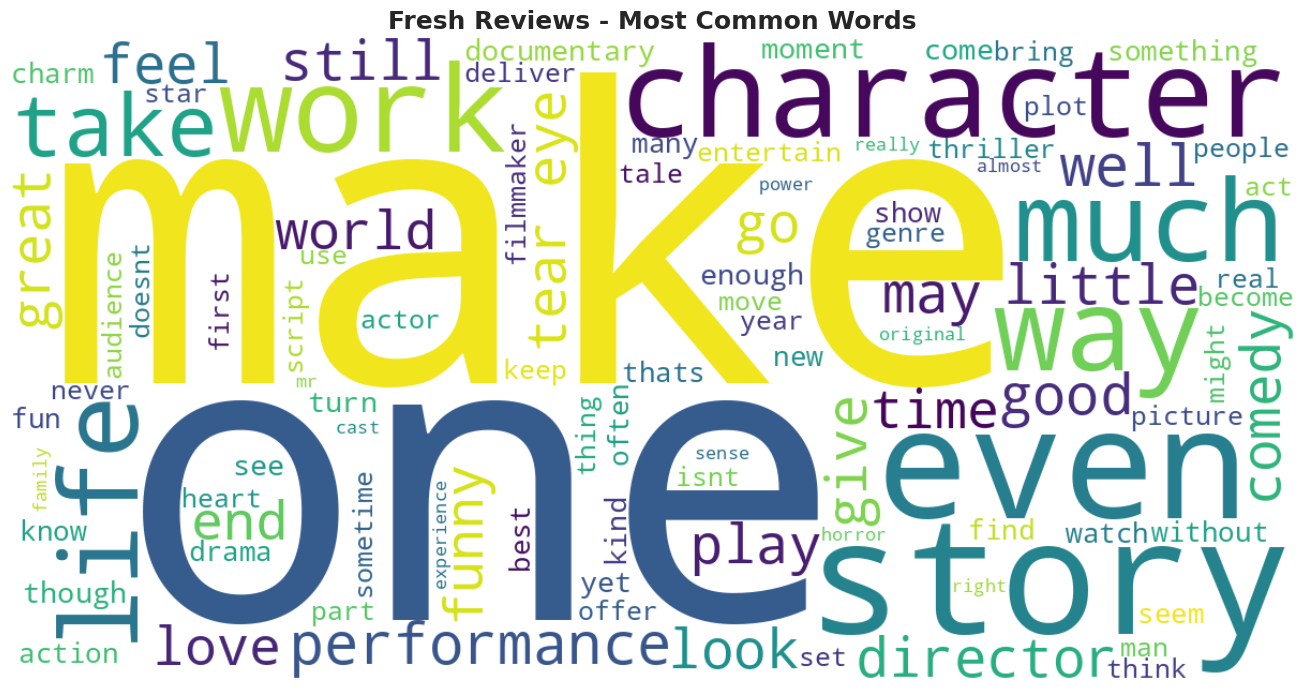

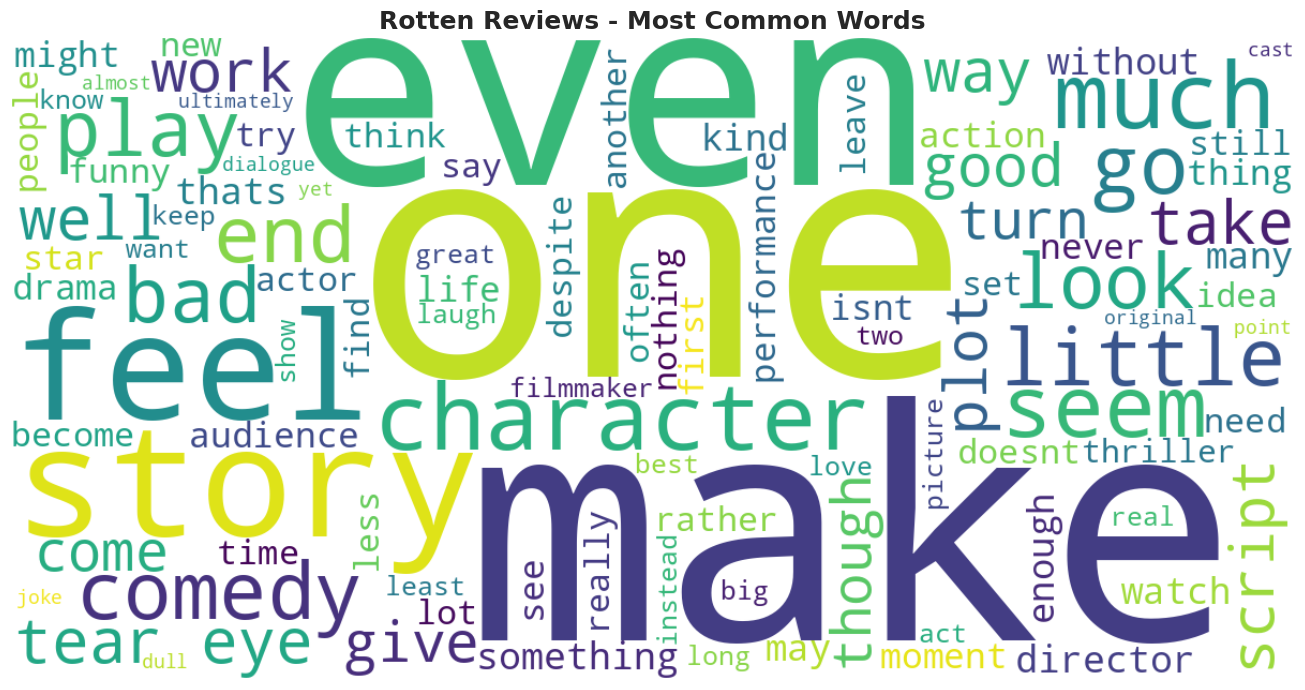

In [40]:
# ========================================
# VISUALIZATION: Word Clouds
# ========================================
print("\n" + "="*60)
print("GENERATING WORD CLOUDS")
print("="*60)

def generate_wordcloud(tokens_series, title):
    all_tokens = [token for tokens in tokens_series for token in tokens]
    if not all_tokens:
        return

    text = ' '.join(all_tokens)
    wordcloud = WordCloud(
        width=1200, height=600,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

fresh_reviews = df[df['review_type'] == 'Fresh']
rotten_reviews = df[df['review_type'] == 'Rotten']

generate_wordcloud(fresh_reviews['tokens'], 'Fresh Reviews - Most Common Words')
generate_wordcloud(rotten_reviews['tokens'], 'Rotten Reviews - Most Common Words')

In [41]:
mismatched_df = df[~df['sentiment_matches']]

print(f"❌ Liczba niezgodnych recenzji: {len(mismatched_df)} ({len(mismatched_df)/len(df)*100:.1f}%)")

mismatched_df[['review_type', 'predicted_sentiment', 'text_cleaned']].sample(10)


❌ Liczba niezgodnych recenzji: 63591 (22.0%)


,review_type,predicted_sentiment,text_cleaned
229098,Fresh,-1,in the end submarine is another smallscale bri...
265843,Rotten,1,i came very close to walking out of the screen...
82677,Fresh,-1,while the picture loses some plot tension by a...
13894,Rotten,1,a fullthrottle videogame ride for the mtv set
61252,Fresh,-1,these two lovebirds are playfully mismatched a...
122651,Fresh,-1,it eventually finds its own rhythm and meaning...
248474,Fresh,-1,even with the piece wobbling between dark psyc...
172254,Rotten,1,in an attempt to be unconventional and surreal...
205972,Fresh,-1,when you sit down to the shining you sit down ...
38701,Rotten,1,asylum is a semiwatchable lurid melodrama but ...


no ten sentyment działa po chuju

#Na razie tutaj bazowa regresja na podstawie tego co wcześniej ustalono


PARSING REVIEW_SCORE TO 1-10 SCALE
✅ Parsing complete:
   Original review_score: 186017
   Parsed to score_10: 186017
   Success rate: 100.0%

📊 Score distribution (1-10 scale):
count    186017.0
mean     6.510287
std      2.151884
min           1.0
25%           5.0
50%           7.0
75%           8.0
max          10.0
Name: score_10, dtype: Float64

📊 Value counts:
score_10
1      1940
2     11177
3      1509
4     20600
5     22488
6     33952
7     10758
8     54426
9     18733
10    10434
Name: count, dtype: Int64


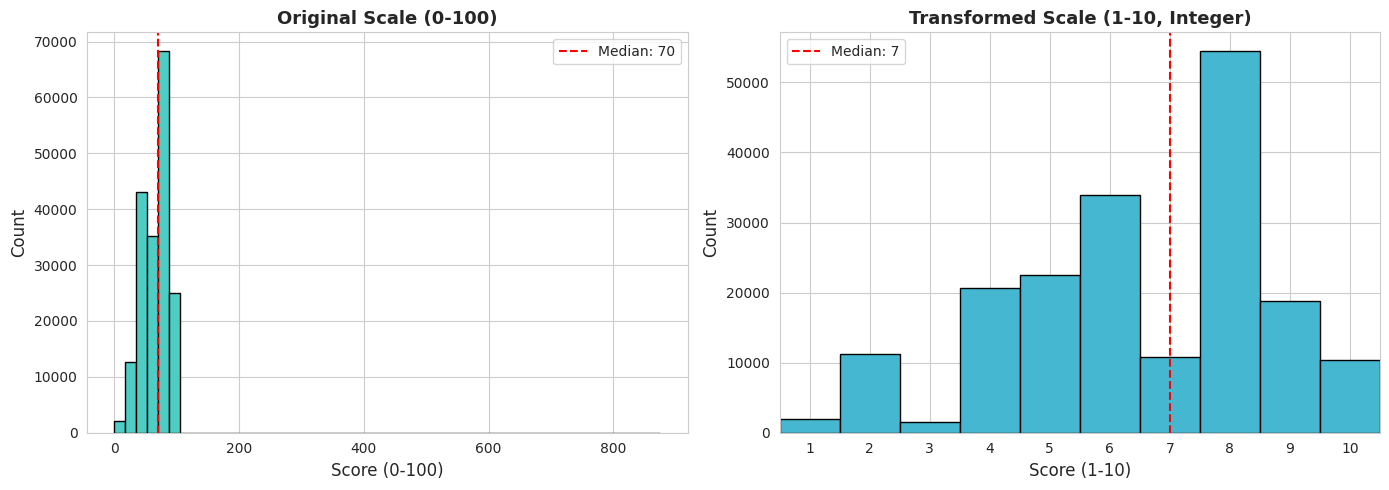

In [42]:
# ========================================
# PARSOWANIE REVIEW_SCORE: 0-100 → 1-10
# ========================================
print("\n" + "="*60)
print("PARSING REVIEW_SCORE TO 1-10 SCALE")
print("="*60)

import re
import numpy as np
import pandas as pd

# Mapowanie ocen literowych na 0-100 (pośredni krok)
GRADE_MAP = {
    "A+": 100, "A": 95, "A-": 90,
    "B+": 87,  "B": 83, "B-": 80,
    "C+": 77,  "C": 73, "C-": 70,
    "D+": 67,  "D": 63, "D-": 60,
    "F": 50
}

def score_to_0_100(x):
    """Parsuje różne formaty → 0-100"""
    if pd.isna(x):
        return np.nan

    s = str(x).strip()

    # 1) Procenty: "84%"
    m = re.match(r"^(\d+(?:\.\d+)?)\s*%$", s)
    if m:
        return float(m.group(1))

    # 2) Ułamek: "3/5", "8/10"
    m = re.match(r"^(\d+(?:\.\d+)?)\s*/\s*(\d+(?:\.\d+)?)$", s)
    if m:
        num, den = float(m.group(1)), float(m.group(2))
        if den > 0:
            return 100.0 * num / den

    # 3) Liczba (zakładamy /5 jeśli ≤5, /100 jeśli ≤100)
    m = re.match(r"^(\d+(?:\.\d+)?)$", s)
    if m:
        num = float(m.group(1))
        if num <= 5:
            return 100.0 * num / 5.0
        elif num <= 10:  # już skala 1-10
            return num * 10.0
        elif num <= 100:
            return num

    # 4) Oceny literowe
    if s.upper().strip() in GRADE_MAP:
        return float(GRADE_MAP[s.upper().strip()])

    return np.nan

# KROK 1: Parsuj do 0-100
df["score_100"] = df["review_score"].apply(score_to_0_100)

# KROK 2: Przekształć 0-100 → 1-10 (CAŁKOWITE)
df["score_10"] = (df["score_100"] / 10.0).round().clip(1, 10).astype('Int64')

# Stats
original_count = df["review_score"].notna().sum()
parsed_count = df["score_10"].notna().sum()
success_rate = (parsed_count / original_count * 100) if original_count > 0 else 0

print(f"✅ Parsing complete:")
print(f"   Original review_score: {original_count}")
print(f"   Parsed to score_10: {parsed_count}")
print(f"   Success rate: {success_rate:.1f}%")

print(f"\n📊 Score distribution (1-10 scale):")
print(df["score_10"].describe())
print(f"\n📊 Value counts:")
print(df["score_10"].value_counts().sort_index())

# Histogram
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Skala 0-100
df["score_100"].dropna().hist(bins=50, ax=axes[0], edgecolor='black', color='#4ECDC4')
axes[0].set_xlabel("Score (0-100)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_title("Original Scale (0-100)", fontsize=13, fontweight='bold')
axes[0].axvline(df["score_100"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_100"].median():.0f}')
axes[0].legend()

# Skala 1-10 (CAŁKOWITE)
df["score_10"].dropna().hist(bins=10, range=(0.5, 10.5), ax=axes[1],
                              edgecolor='black', color='#45B7D1', align='mid')
axes[1].set_xlabel("Score (1-10)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_title("Transformed Scale (1-10, Integer)", fontsize=13, fontweight='bold')
axes[1].axvline(df["score_10"].median(), color='red', linestyle='--',
                label=f'Median: {df["score_10"].median():.0f}')
axes[1].legend()
axes[1].set_xticks(range(1, 11))
axes[1].set_xlim(0.5, 10.5)

plt.tight_layout()
plt.show()



N-GRAM ANALYSIS: LOG-ODDS FOR REVIEW SCORES

📊 Analyzing 178134 reviews with valid scores
Score range: 1 - 10

🔺 TOP 30 N-GRAMS BOOSTING SCORE (positive log-odds)
       ngram  log_odds
 never loses  5.466490
 masterpiece  4.676523
never boring  4.198828
   marvelous  4.146900
    not only  4.095333
   cant wait  3.858472
   kill bill  3.838433
     sublime  3.832920
   afraid to  3.789916
   even when  3.713866
   be missed  3.702133
     perfect  3.635244
  perfection  3.600415
     hell of  3.581939
 ratatouille  3.554853
   wonderful  3.538334
 masterfully  3.519615
 brilliantly  3.504972
    the void  3.503113
  unmissable  3.495483
exhilarating  3.494096
     no less  3.493981
  quite like  3.480651
    at worst  3.469376
 oscarworthy  3.453654
electrifying  3.426488
 even better  3.426298
   brilliant  3.412966
blade runner  3.407611
      leighs  3.402606

🔻 TOP 30 N-GRAMS LOWERING SCORE (negative log-odds)
         ngram  log_odds
    incoherent -3.972874
       rubbish -4.00

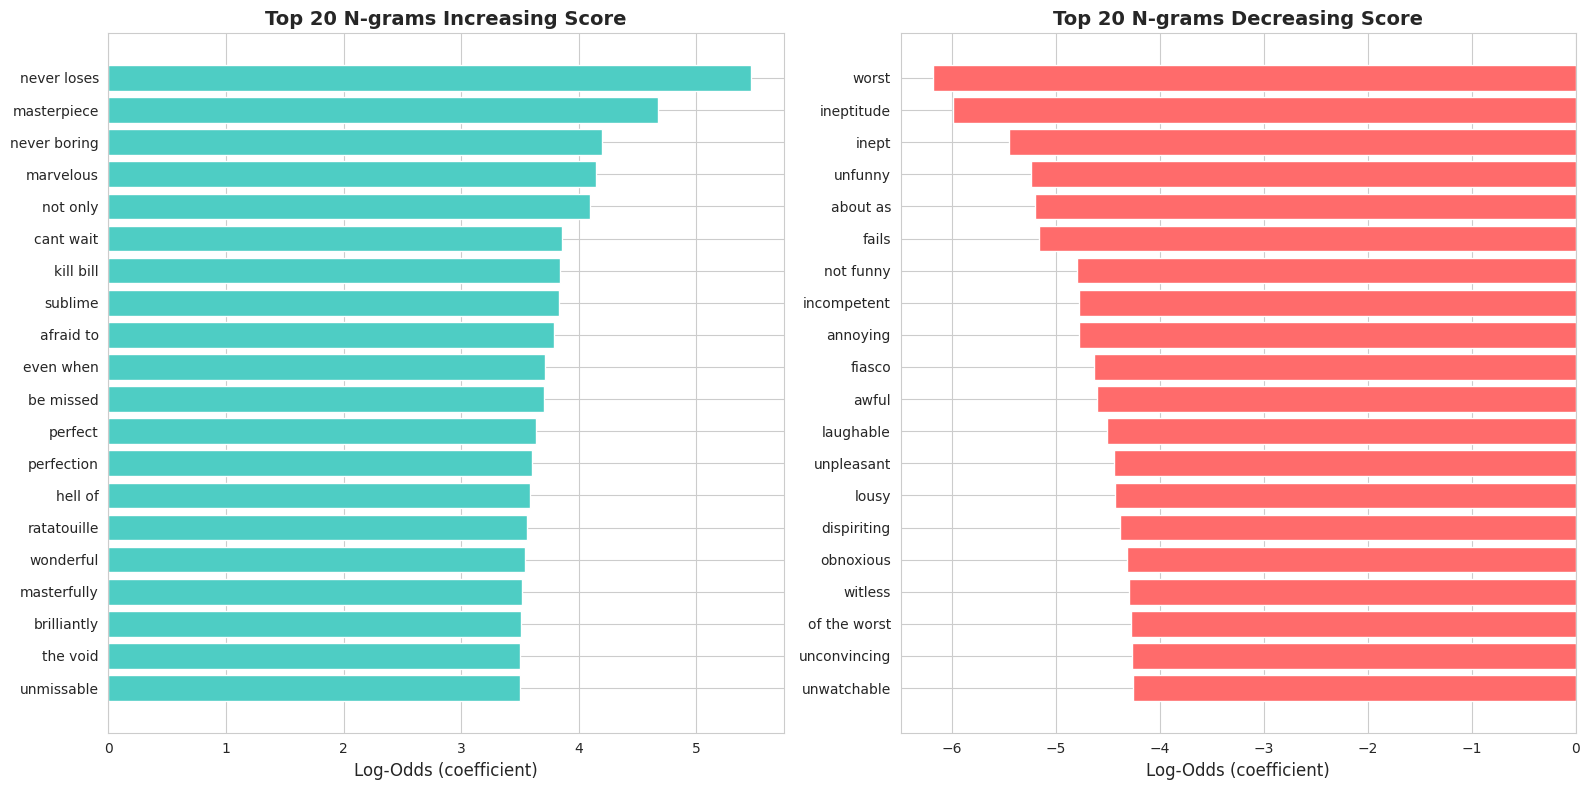


✅ Analysis complete. Total features: 20000


In [43]:
# ========================================
# ANALIZA N-GRAMÓW I LOG-ODDS
# ========================================
print("\n" + "="*60)
print("N-GRAM ANALYSIS: LOG-ODDS FOR REVIEW SCORES")
print("="*60)

# Przygotuj dane (tylko te z review_score)
df_for_ngrams = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"\n📊 Analyzing {len(df_for_ngrams)} reviews with valid scores")
print(f"Score range: {df_for_ngrams['score_10'].min():.0f} - {df_for_ngrams['score_10'].max():.0f}")

# Wytrenuj prosty model Ridge na TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

vectorizer_ngrams = TfidfVectorizer(
    ngram_range=(1, 3),      # unigramy + bigramy + trigramy
    min_df=10,               # minimum 10 wystąpień (filtruje rzadkie)
    max_features=20000,      # top 20k najczęstszych
    sublinear_tf=True        # log-scaling TF
)

X_ngrams = vectorizer_ngrams.fit_transform(df_for_ngrams["text_cleaned"])
y_ngrams = df_for_ngrams["score_10"].astype(float)

# Prosty Ridge (bez split, bo to tylko analiza)
ridge_ngrams = Ridge(alpha=1.0)
ridge_ngrams.fit(X_ngrams, y_ngrams)

# Wyciągnij feature names i współczynniki
feature_names = vectorizer_ngrams.get_feature_names_out()
coefficients = ridge_ngrams.coef_

# Stwórz DataFrame: n-gram → współczynnik
ngram_weights = pd.DataFrame({
    'ngram': feature_names,
    'log_odds': coefficients
})

# Posortuj
ngram_weights = ngram_weights.sort_values('log_odds', ascending=False)

print("\n" + "="*60)
print("🔺 TOP 30 N-GRAMS BOOSTING SCORE (positive log-odds)")
print("="*60)
print(ngram_weights.head(30).to_string(index=False))

print("\n" + "="*60)
print("🔻 TOP 30 N-GRAMS LOWERING SCORE (negative log-odds)")
print("="*60)
print(ngram_weights.tail(30).to_string(index=False))

# Opcjonalnie: wizualizacja top 20 każdego
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top pozytywne
top_positive = ngram_weights.head(20)
axes[0].barh(top_positive['ngram'], top_positive['log_odds'], color='#4ECDC4')
axes[0].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[0].set_title('Top 20 N-grams Increasing Score', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Top negatywne
top_negative = ngram_weights.tail(20).sort_values('log_odds')
axes[1].barh(top_negative['ngram'], top_negative['log_odds'], color='#FF6B6B')
axes[1].set_xlabel('Log-Odds (coefficient)', fontsize=12)
axes[1].set_title('Top 20 N-grams Decreasing Score', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete. Total features: {len(feature_names)}")



TRAINING REGRESSION MODEL: TEXT → SCORE (1-10)
📊 Dataset: 178134 reviews
   Score range: 1.0 - 10.0
   Train: 142507 | Test: 35627

🚀 Training...
✅ Complete

📊 MODEL PERFORMANCE (1-10 scale)
Train MAE: 1.175 points
Test MAE:  1.371 points
Test RMSE: 1.734 points
Test R²:   0.352

📏 Prediction Tolerance:
   Within ±0.5 points: 25.3%
   Within ±1.0 points: 46.4%
   Within ±1.5 points: 63.8%


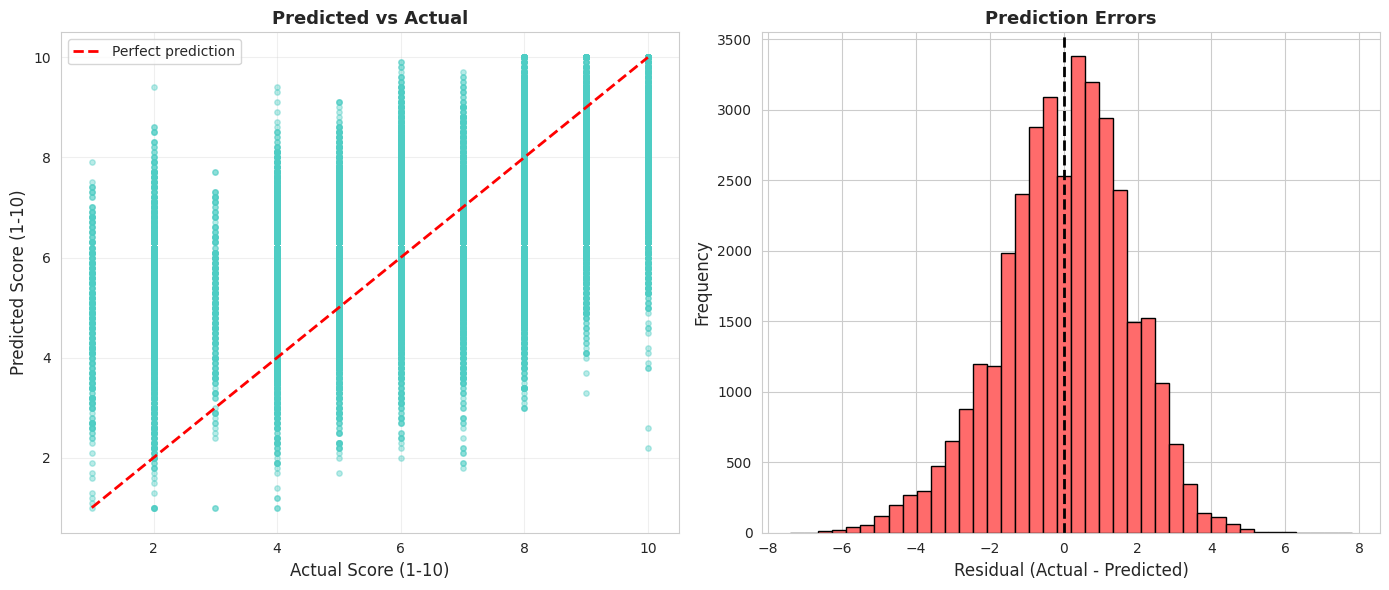


✅ Model trained on 1-10 scale


In [44]:
# ========================================
# TRENING MODELU: TEXT → SCORE (1-10)
# ========================================
print("\n" + "="*60)
print("TRAINING REGRESSION MODEL: TEXT → SCORE (1-10)")
print("="*60)

# Filtruj dane
df_with_score = df[
    df["score_10"].notna() &
    (df["text_cleaned"].str.strip() != "")
].copy()

print(f"📊 Dataset: {len(df_with_score)} reviews")
print(f"   Score range: {df_with_score['score_10'].min():.1f} - {df_with_score['score_10'].max():.1f}")

X = df_with_score["text_cleaned"]
y = df_with_score["score_10"]  # ← ZMIANA: używamy skali 1-10

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Train: {len(X_train)} | Test: {len(X_test)}")

# Model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

regressor = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=30000)),
    ("ridge", Ridge(alpha=1.0))  # może zmniejsz alpha dla mniejszej skali
])

print("\n🚀 Training...")
regressor.fit(X_train, y_train)
print("✅ Complete")

# Predykcje (clip do 1-10, round do 1 miejsca po przecinku)
pred_train = regressor.predict(X_train).clip(1, 10).round(1)
pred_test = regressor.predict(X_test).clip(1, 10).round(1)

# Metryki
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
r2_test = r2_score(y_test, pred_test)

print("\n" + "="*60)
print("📊 MODEL PERFORMANCE (1-10 scale)")
print("="*60)
print(f"Train MAE: {mae_train:.3f} points")
print(f"Test MAE:  {mae_test:.3f} points")
print(f"Test RMSE: {rmse_test:.3f} points")
print(f"Test R²:   {r2_test:.3f}")

# Accuracy-like (tolerance na skali 1-10)
within_05 = (np.abs(y_test - pred_test) <= 0.5).mean()
within_10 = (np.abs(y_test - pred_test) <= 1.0).mean()
within_15 = (np.abs(y_test - pred_test) <= 1.5).mean()

print(f"\n📏 Prediction Tolerance:")
print(f"   Within ±0.5 points: {within_05:.1%}")
print(f"   Within ±1.0 points: {within_10:.1%}")
print(f"   Within ±1.5 points: {within_15:.1%}")

# Scatter plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, pred_test, alpha=0.4, s=15, color='#4ECDC4')
axes[0].plot([1, 10], [1, 10], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel("Actual Score (1-10)", fontsize=12)
axes[0].set_ylabel("Predicted Score (1-10)", fontsize=12)
axes[0].set_title("Predicted vs Actual", fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0.5, 10.5)
axes[0].set_ylim(0.5, 10.5)

# Residuals
residuals = y_test - pred_test
axes[1].hist(residuals, bins=40, edgecolor='black', color='#FF6B6B')
axes[1].set_xlabel("Residual (Actual - Predicted)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_title("Prediction Errors", fontsize=13, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

print(f"\n✅ Model trained on 1-10 scale")


In [45]:
# ========================================
# PREDYKCJA DLA CAŁEGO DATASETU
# ========================================
print("\n" + "="*60)
print("GENERATING PREDICTIONS (1-10 scale)")
print("="*60)

# Predykcja
df["predicted_score_10"] = np.nan
mask = df["text_cleaned"].notna() & (df["text_cleaned"].str.strip() != "")

df.loc[mask, "predicted_score_10"] = (
    regressor.predict(df.loc[mask, "text_cleaned"])
    .clip(1, 10)
    .round(1)
)

print(f"✅ Predictions for {mask.sum()} reviews")
print(f"\n📊 Predicted score distribution:")
print(df["predicted_score_10"].describe())

# Residuals
df["score_residual"] = df["score_10"] - df["predicted_score_10"]

print(f"\n📊 Residuals:")
print(df["score_residual"].describe())

# Możesz też skonwertować z powrotem do 0-100 dla wizualizacji
df["predicted_score_100"] = (df["predicted_score_10"] * 10).round().astype("Int64")

print("\n✅ Available columns:")
print("   - score_10 (target, 1-10)")
print("   - predicted_score_10 (model output, 1-10)")
print("   - predicted_score_100 (converted back, 0-100)")
print("   - score_residual (error)")



GENERATING PREDICTIONS (1-10 scale)
✅ Predictions for 280632 reviews

📊 Predicted score distribution:
count    280632.000000
mean          6.515410
std           1.400236
min           1.000000
25%           5.600000
50%           6.600000
75%           7.500000
max          10.000000
Name: predicted_score_10, dtype: float64

📊 Residuals:
count    178134.0
mean     0.000275
std      1.537529
min          -7.4
25%          -1.0
50%           0.1
75%           1.1
max           7.8
Name: score_residual, dtype: Float64

✅ Available columns:
   - score_10 (target, 1-10)
   - predicted_score_10 (model output, 1-10)
   - predicted_score_100 (converted back, 0-100)
   - score_residual (error)



CALCULATING REVIEWER BURST DETECTION
🔄 Processing burst detection per reviewer...

✅ Reviewer burst detection complete:
   Burst 24h (>20 reviews): 26444 reviews (9.3%)
   Burst 7d (>50 reviews): 22255 reviews (7.8%)
   Normalized burst (>30% in 24h): 17854 reviews (6.3%)
   Any burst: 31304 reviews (11.0%)

ANALYZING BURSTY REVIEWERS

👤 Reviewers with burst activity: 2256

🚨 TOP 20 Most Bursty Reviewers:
       critic_name  max_burst_24h  max_burst_7d  max_burst_ratio first_review last_review  total_reviews
       Roger Ebert           2456          2456         0.382733   2000-01-01  2006-01-20           3158
James Berardinelli           1709          1709         0.325338   2000-01-01  2008-06-11           1090
       Susan Stark            922           922         0.668600   2000-01-01  2008-10-18            305
   Owen Gleiberman            824           829         0.234691   2000-01-01  2011-09-14            352
    Desson Thomson            687           687         0.365815 

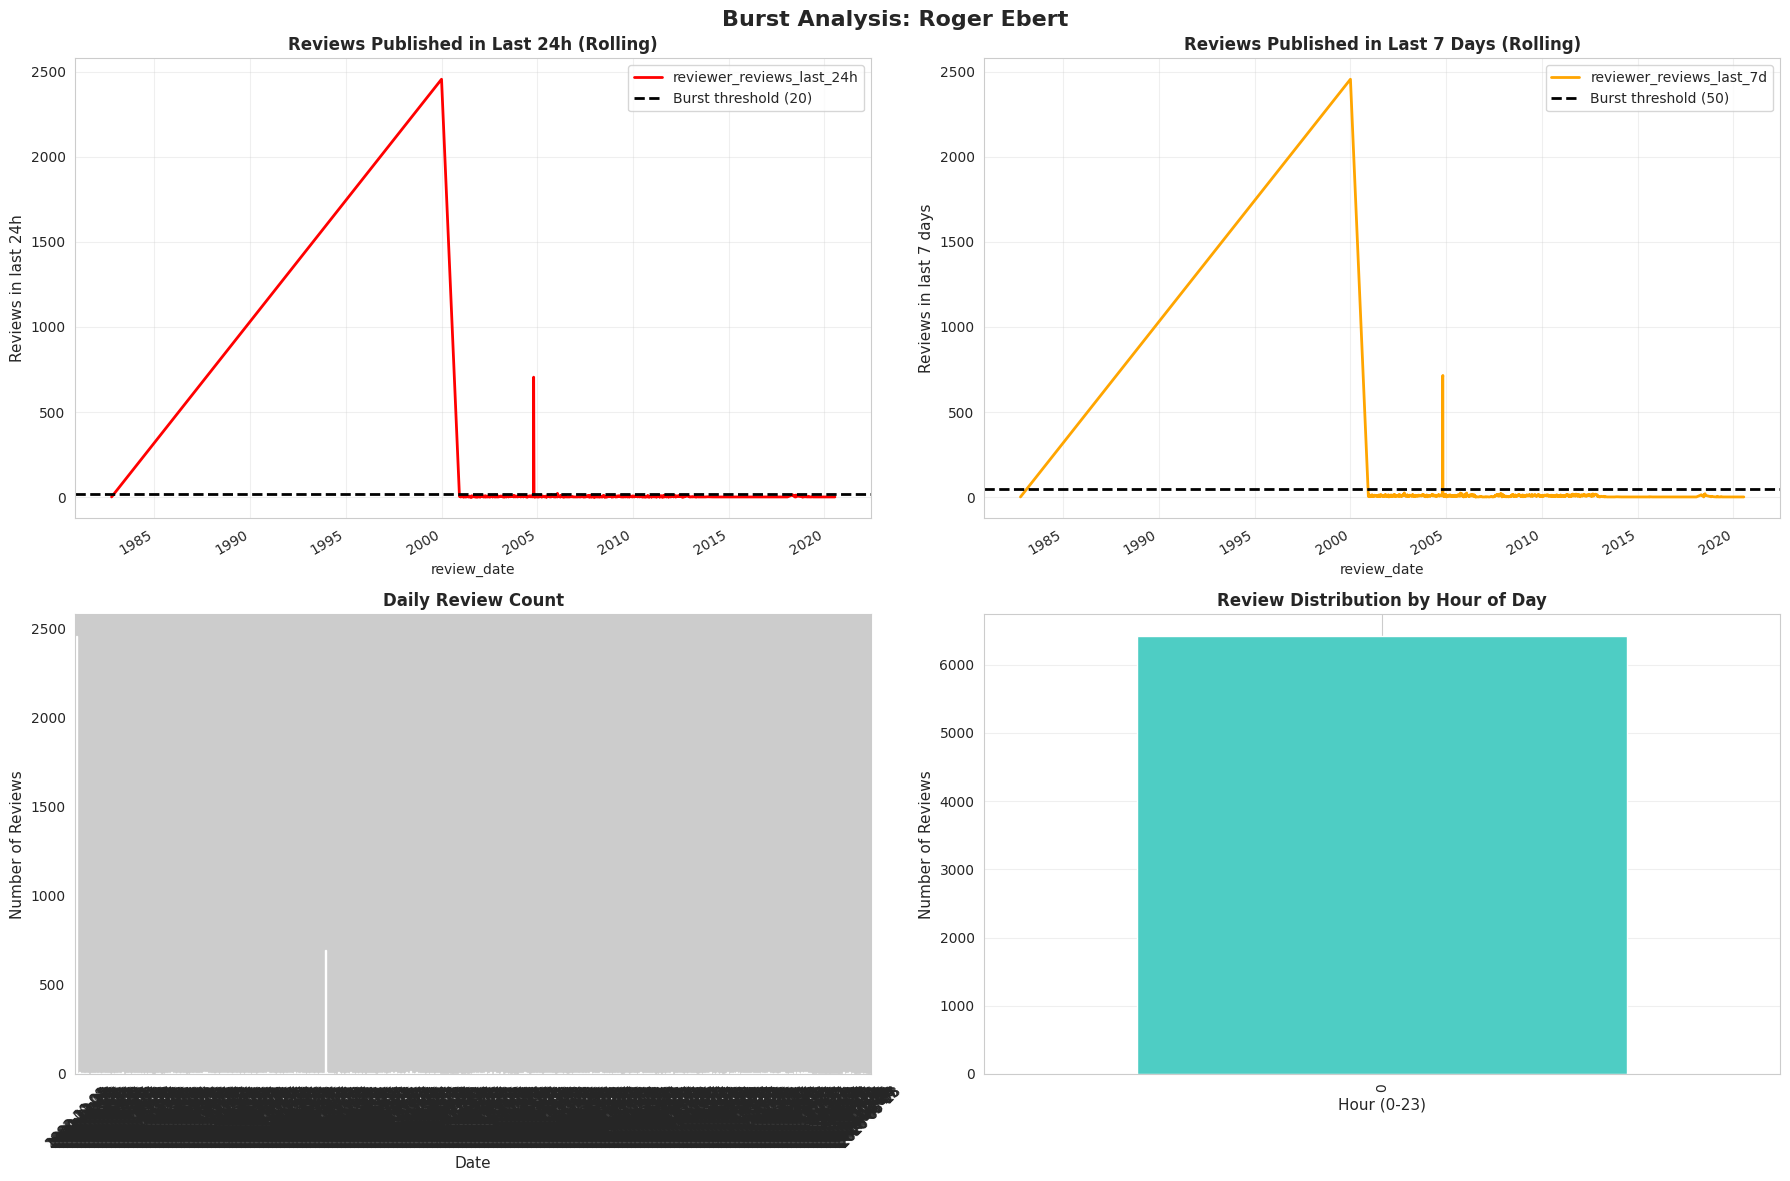


📊 Burst Analysis for 'Roger Ebert':
   Total reviews: 6417
   Peak 24h burst: 2456 reviews
   Peak 7d burst: 2456 reviews
   Max burst ratio: 38.3%
   Reviews in burst periods: 3182
   Activity span: 13798 days

REVIEWER BURST THRESHOLD COMPARISON

24-hour window thresholds:
Threshold    Reviews      % of Reviews    Reviewers   
------------------------------------------------------------
>5           49493        17.44          % 483         
>10          30616        10.79          % 285         
>15          27842        9.81           % 211         
>20          26444        9.32           % 178         
>30          24235        8.54           % 125         
>50          21671        7.63           % 85          
>100         17887        6.30           % 45          

7-day window thresholds:
Threshold    Reviews      % of Reviews    Reviewers   
------------------------------------------------------------
>20          27803        9.79           % 199         
>30          2516

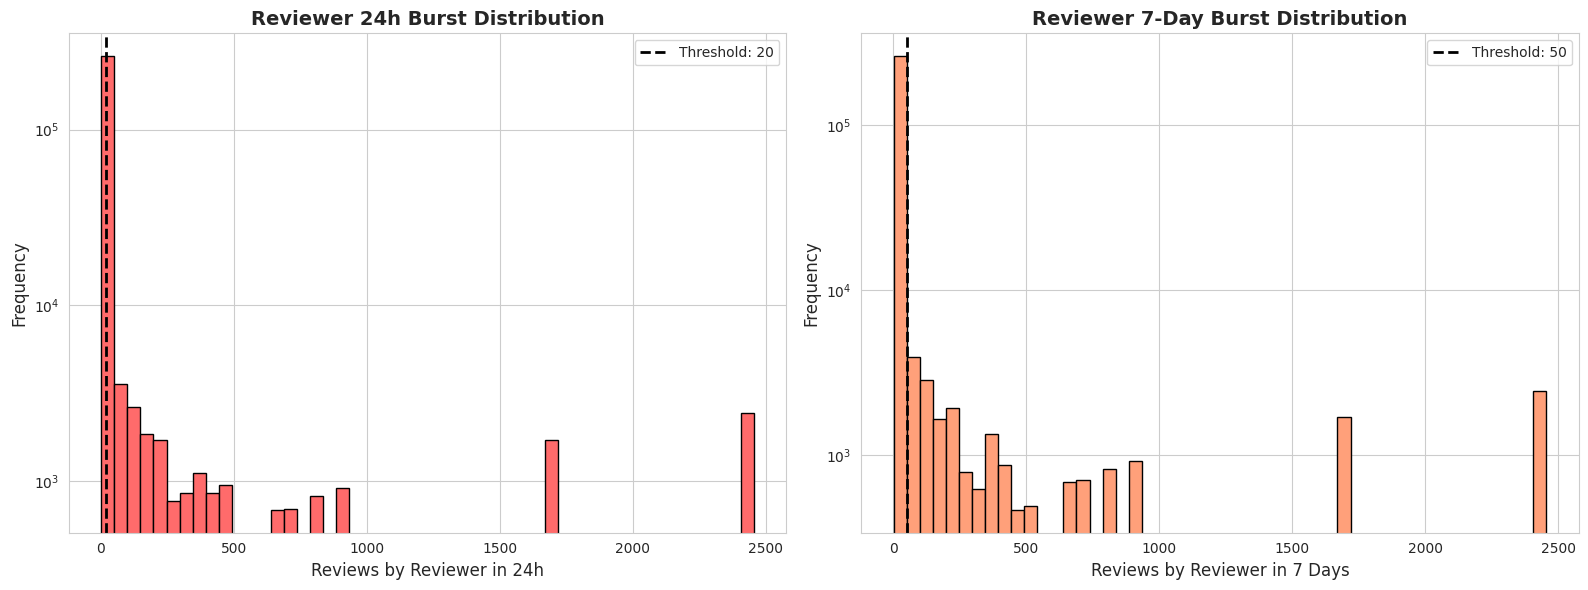

In [46]:
# detekcja większej ilości recenzji w trakcie 24h recenzenta - raczej nie powinien np wystawić 20 recenzji na dzień
from datetime import timedelta
import pandas as pd
import numpy as np

print("\n" + "="*60)
print("CALCULATING REVIEWER BURST DETECTION")
print("="*60)

def calculate_reviewer_burst(group):
    """
    Wykrywa burst activity dla pojedynczego recenzenta.
    Podejrzane: wiele recenzji w krótkim czasie.
    """
    group = group.sort_values('review_date').copy()
    total_reviews = len(group)

    counts_24h = []
    counts_7d = []

    for idx, row in group.iterrows():
        current_time = row['review_date']

        # Okno 24h
        window_24h_start = current_time - timedelta(hours=24)
        count_24h = ((group['review_date'] >= window_24h_start) &
                     (group['review_date'] <= current_time)).sum()
        counts_24h.append(count_24h)

        # Okno 7 dni
        window_7d_start = current_time - timedelta(days=7)
        count_7d = ((group['review_date'] >= window_7d_start) &
                    (group['review_date'] <= current_time)).sum()
        counts_7d.append(count_7d)

    group['reviewer_reviews_last_24h'] = counts_24h
    group['reviewer_reviews_last_7d'] = counts_7d

    # Normalizacja
    group['reviewer_burst_ratio_24h'] = group['reviewer_reviews_last_24h'] / total_reviews

    return group

# Zastosuj per reviewer
print("🔄 Processing burst detection per reviewer...")
df = df.groupby('critic_name', group_keys=False).apply(
    calculate_reviewer_burst
)

# ========================================
# KROK 2: Flagi burst dla recenzentów
# ========================================

# Thresholdy - dostosuj do swoich danych
df['is_reviewer_burst_24h'] = df['reviewer_reviews_last_24h'] > 20  # >20 recenzji w 24h
df['is_reviewer_burst_7d'] = df['reviewer_reviews_last_7d'] > 50     # >50 recenzji w tydzień

# Normalized (np. >30% wszystkich recenzji w 24h)
df['is_reviewer_burst_normalized'] = df['reviewer_burst_ratio_24h'] > 0.3

# Combined
df['is_reviewer_burst_any'] = (
    df['is_reviewer_burst_24h'] |
    df['is_reviewer_burst_7d'] |
    df['is_reviewer_burst_normalized']
)

print(f"\n✅ Reviewer burst detection complete:")
print(f"   Burst 24h (>20 reviews): {df['is_reviewer_burst_24h'].sum()} reviews ({df['is_reviewer_burst_24h'].mean()*100:.1f}%)")
print(f"   Burst 7d (>50 reviews): {df['is_reviewer_burst_7d'].sum()} reviews ({df['is_reviewer_burst_7d'].mean()*100:.1f}%)")
print(f"   Normalized burst (>30% in 24h): {df['is_reviewer_burst_normalized'].sum()} reviews ({df['is_reviewer_burst_normalized'].mean()*100:.1f}%)")
print(f"   Any burst: {df['is_reviewer_burst_any'].sum()} reviews ({df['is_reviewer_burst_any'].mean()*100:.1f}%)")

# ========================================
# KROK 3: Identyfikacja najgorszych recenzentów
# ========================================
print("\n" + "="*60)
print("ANALYZING BURSTY REVIEWERS")
print("="*60)

# Agreguj per reviewer
bursty_reviewers = df[df['is_reviewer_burst_any']].groupby('critic_name').agg({
    'reviewer_reviews_last_24h': 'max',
    'reviewer_reviews_last_7d': 'max',
    'reviewer_burst_ratio_24h': 'max',
    'review_date': ['min', 'max'],
    'review_content': 'count'
}).reset_index()

bursty_reviewers.columns = ['critic_name', 'max_burst_24h', 'max_burst_7d',
                             'max_burst_ratio', 'first_review', 'last_review',
                             'total_reviews']
bursty_reviewers = bursty_reviewers.sort_values('max_burst_24h', ascending=False)

print(f"\n👤 Reviewers with burst activity: {len(bursty_reviewers)}")
print("\n🚨 TOP 20 Most Bursty Reviewers:")
print(bursty_reviewers.head(20).to_string(index=False))

# ========================================
# KROK 4: Wizualizacja konkretnego recenzenta
# ========================================
if len(bursty_reviewers) > 0:
    import matplotlib.pyplot as plt

    example_reviewer = bursty_reviewers.iloc[0]['critic_name']
    reviewer_data = df[df['critic_name'] == example_reviewer].sort_values('review_date')

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Burst Analysis: {example_reviewer}', fontsize=16, fontweight='bold')

    # Plot 1: Time series - reviews in last 24h
    reviewer_data.set_index('review_date')['reviewer_reviews_last_24h'].plot(
        ax=axes[0, 0], color='red', linewidth=2
    )
    axes[0, 0].axhline(y=20, color='black', linestyle='--',
                       linewidth=2, label='Burst threshold (20)')
    axes[0, 0].set_title('Reviews Published in Last 24h (Rolling)', fontweight='bold')
    axes[0, 0].set_ylabel('Reviews in last 24h', fontsize=11)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Time series - reviews in last 7d
    reviewer_data.set_index('review_date')['reviewer_reviews_last_7d'].plot(
        ax=axes[0, 1], color='orange', linewidth=2
    )
    axes[0, 1].axhline(y=50, color='black', linestyle='--',
                       linewidth=2, label='Burst threshold (50)')
    axes[0, 1].set_title('Reviews Published in Last 7 Days (Rolling)', fontweight='bold')
    axes[0, 1].set_ylabel('Reviews in last 7 days', fontsize=11)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Daily distribution
    daily_counts = reviewer_data['review_date'].dt.date.value_counts().sort_index()
    daily_counts.plot(kind='bar', ax=axes[1, 0], color='steelblue', width=0.8)
    axes[1, 0].set_title('Daily Review Count', fontweight='bold')
    axes[1, 0].set_ylabel('Number of Reviews', fontsize=11)
    axes[1, 0].set_xlabel('Date', fontsize=11)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Hourly distribution (if timestamps available)
    if pd.api.types.is_datetime64_any_dtype(reviewer_data['review_date']):
        hourly_counts = reviewer_data['review_date'].dt.hour.value_counts().sort_index()
        hourly_counts.plot(kind='bar', ax=axes[1, 1], color='#4ECDC4', width=0.8)
        axes[1, 1].set_title('Review Distribution by Hour of Day', fontweight='bold')
        axes[1, 1].set_ylabel('Number of Reviews', fontsize=11)
        axes[1, 1].set_xlabel('Hour (0-23)', fontsize=11)
        axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Stats dla tego recenzenta
    print(f"\n📊 Burst Analysis for '{example_reviewer}':")
    print(f"   Total reviews: {len(reviewer_data)}")
    print(f"   Peak 24h burst: {reviewer_data['reviewer_reviews_last_24h'].max()} reviews")
    print(f"   Peak 7d burst: {reviewer_data['reviewer_reviews_last_7d'].max()} reviews")
    print(f"   Max burst ratio: {reviewer_data['reviewer_burst_ratio_24h'].max()*100:.1f}%")
    print(f"   Reviews in burst periods: {reviewer_data['is_reviewer_burst_any'].sum()}")
    print(f"   Activity span: {(reviewer_data['review_date'].max() - reviewer_data['review_date'].min()).days} days")

# ========================================
# KROK 5: Porównanie thresholds
# ========================================
print("\n" + "="*60)
print("REVIEWER BURST THRESHOLD COMPARISON")
print("="*60)

thresholds_24h = [5, 10, 15, 20, 30, 50, 100]
thresholds_7d = [20, 30, 50, 75, 100, 150, 200]

print("\n24-hour window thresholds:")
print(f"{'Threshold':<12} {'Reviews':<12} {'% of Reviews':<15} {'Reviewers':<12}")
print("-"*60)

for thresh in thresholds_24h:
    review_count = (df['reviewer_reviews_last_24h'] > thresh).sum()
    review_pct = review_count / len(df) * 100
    reviewer_count = df[df['reviewer_reviews_last_24h'] > thresh]['critic_name'].nunique()

    print(f">{thresh:<11} {review_count:<12} {review_pct:<15.2f}% {reviewer_count:<12}")

print("\n7-day window thresholds:")
print(f"{'Threshold':<12} {'Reviews':<12} {'% of Reviews':<15} {'Reviewers':<12}")
print("-"*60)

for thresh in thresholds_7d:
    review_count = (df['reviewer_reviews_last_7d'] > thresh).sum()
    review_pct = review_count / len(df) * 100
    reviewer_count = df[df['reviewer_reviews_last_7d'] > thresh]['critic_name'].nunique()

    print(f">{thresh:<11} {review_count:<12} {review_pct:<15.2f}% {reviewer_count:<12}")

# ========================================
# KROK 6: Statystyki ogólne
# ========================================
print("\n" + "="*60)
print("REVIEWER BURST STATISTICS")
print("="*60)

print("\n📈 24h burst intensity distribution:")
print(f"   Mean: {df['reviewer_reviews_last_24h'].mean():.2f}")
print(f"   Median: {df['reviewer_reviews_last_24h'].median():.1f}")
print(f"   75th percentile: {df['reviewer_reviews_last_24h'].quantile(0.75):.1f}")
print(f"   95th percentile: {df['reviewer_reviews_last_24h'].quantile(0.95):.1f}")
print(f"   99th percentile: {df['reviewer_reviews_last_24h'].quantile(0.99):.1f}")
print(f"   Max: {df['reviewer_reviews_last_24h'].max():.0f}")

print("\n📈 7-day burst intensity distribution:")
print(f"   Mean: {df['reviewer_reviews_last_7d'].mean():.2f}")
print(f"   Median: {df['reviewer_reviews_last_7d'].median():.1f}")
print(f"   75th percentile: {df['reviewer_reviews_last_7d'].quantile(0.75):.1f}")
print(f"   95th percentile: {df['reviewer_reviews_last_7d'].quantile(0.95):.1f}")
print(f"   99th percentile: {df['reviewer_reviews_last_7d'].quantile(0.99):.1f}")
print(f"   Max: {df['reviewer_reviews_last_7d'].max():.0f}")

# Histogramy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 24h bursts
df['reviewer_reviews_last_24h'].hist(bins=50, ax=axes[0], color='#FF6B6B', edgecolor='black')
axes[0].axvline(20, color='black', linestyle='--', linewidth=2, label='Threshold: 20')
axes[0].set_xlabel('Reviews by Reviewer in 24h', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Reviewer 24h Burst Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].set_yscale('log')

# 7d bursts
df['reviewer_reviews_last_7d'].hist(bins=50, ax=axes[1], color='#FFA07A', edgecolor='black')
axes[1].axvline(50, color='black', linestyle='--', linewidth=2, label='Threshold: 50')
axes[1].set_xlabel('Reviews by Reviewer in 7 Days', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Reviewer 7-Day Burst Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()



In [47]:
#Statystyki recenzentów

# 1. Podstawowe statystyki recenzenta
reviewer_stats = df.groupby('critic_name').agg({
    'review_date': ['count', 'min', 'max'],  # ile recenzji, zakres dat
    'review_type': lambda x: (x == 'Fresh').mean(),  # % pozytywnych
    'movie_title': 'nunique',  # ile różnych filmów
    'score_10': ['mean', 'std'],  # średnia ocena, wariancja
    'text_length_cleaned': 'mean'  # średnia długość tekstu
}).reset_index()

reviewer_stats.columns = ['critic_name', 'review_count', 'first_review',
                          'last_review', 'positive_ratio', 'unique_movies',
                          'avg_score', 'score_std', 'avg_text_length']

# 2. Reviewer deviation (web:12) - jak różni się od średniej
reviewer_stats['deviation_from_mean'] = np.abs(
    reviewer_stats['avg_score'] - df['score_10'].mean()
)

# 3. Activity span
reviewer_stats['days_active'] = (
    reviewer_stats['last_review'] - reviewer_stats['first_review']
).dt.days

# 4. Suspicious patterns
reviewer_stats['is_suspicious'] = (
    (reviewer_stats['review_count'] < 5) |  # mało recenzji
    (reviewer_stats['positive_ratio'] > 0.95) |  # tylko pozytywne
    (reviewer_stats['positive_ratio'] < 0.05) |  # tylko negatywne
    (reviewer_stats['days_active'] < 30)  # krótki okres aktywności
)

# 5. Merge z głównym df
df = df.merge(reviewer_stats, on='critic_name', how='left')

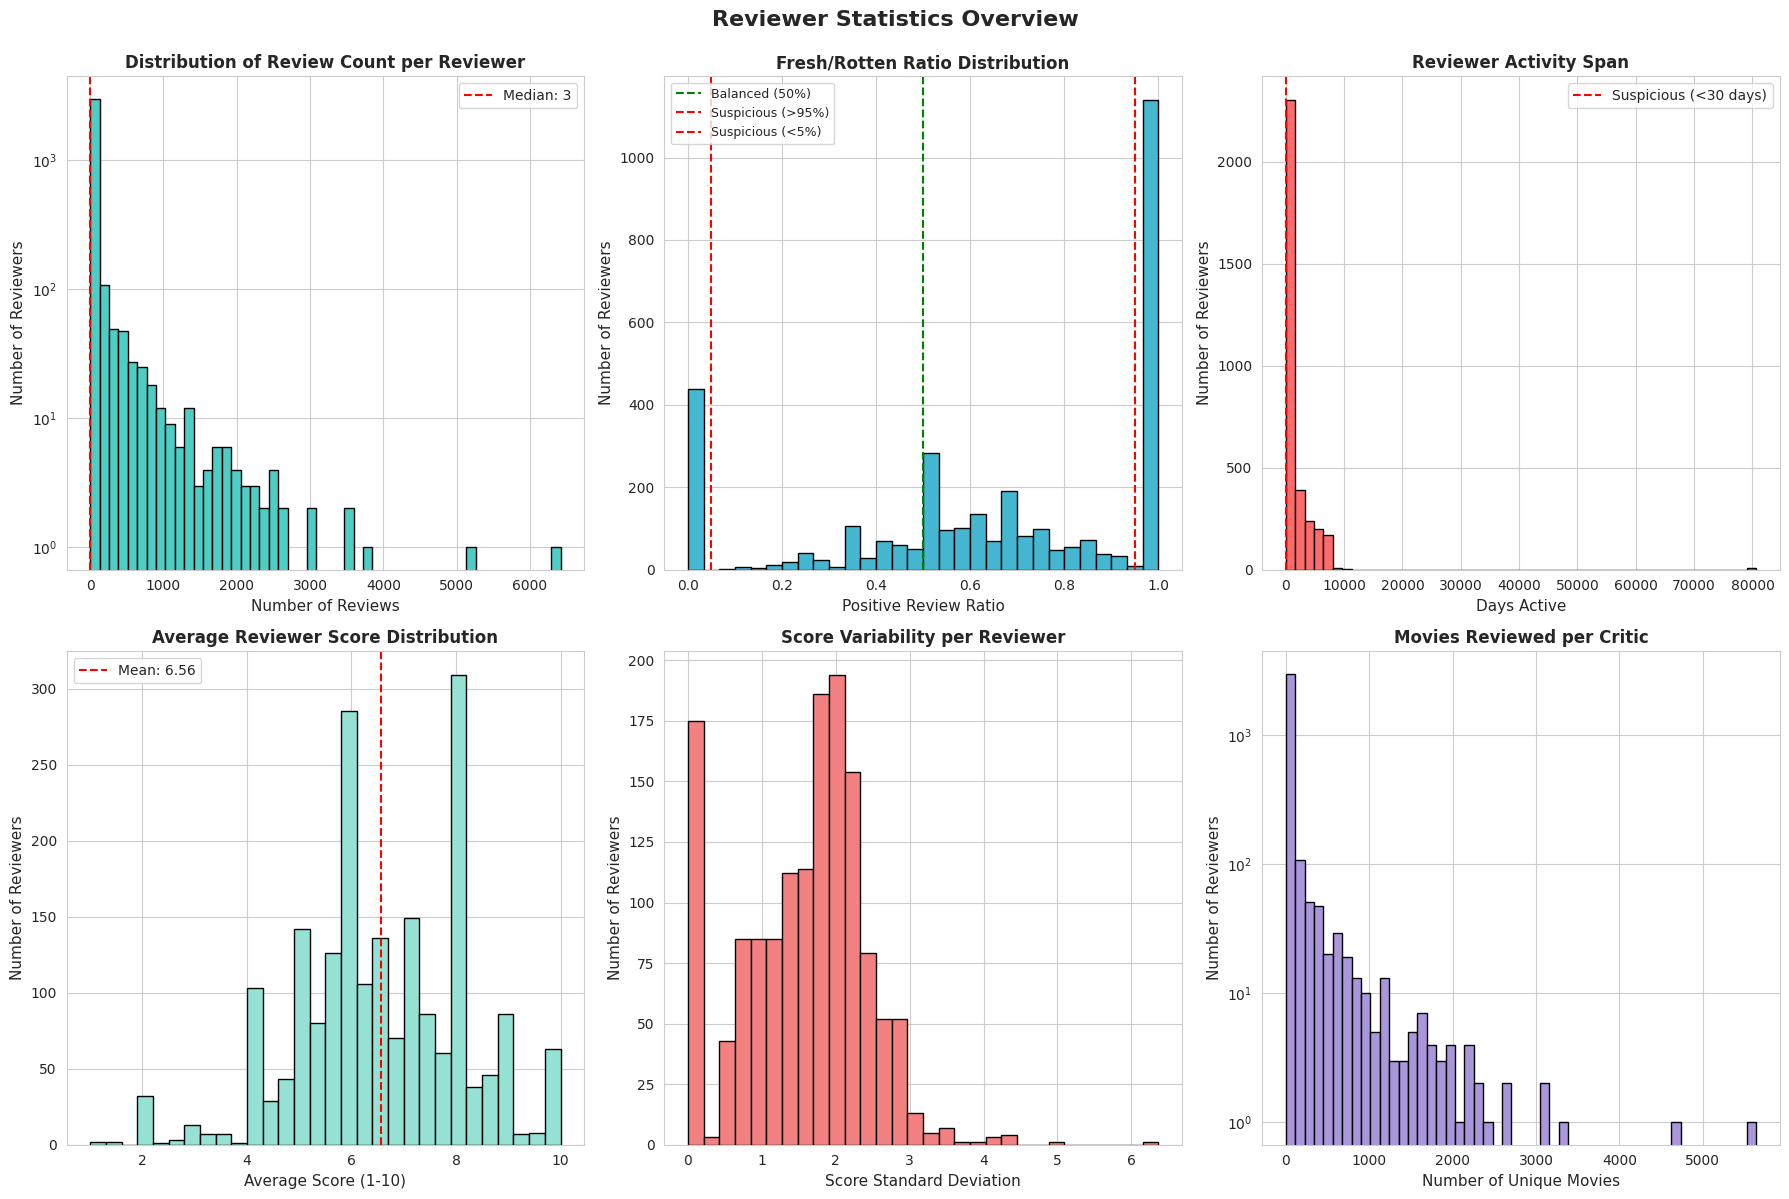


📊 Reviewer Classification:
   Suspicious reviewers: 1981 (59.6%)
   Normal reviewers: 1343 (40.4%)


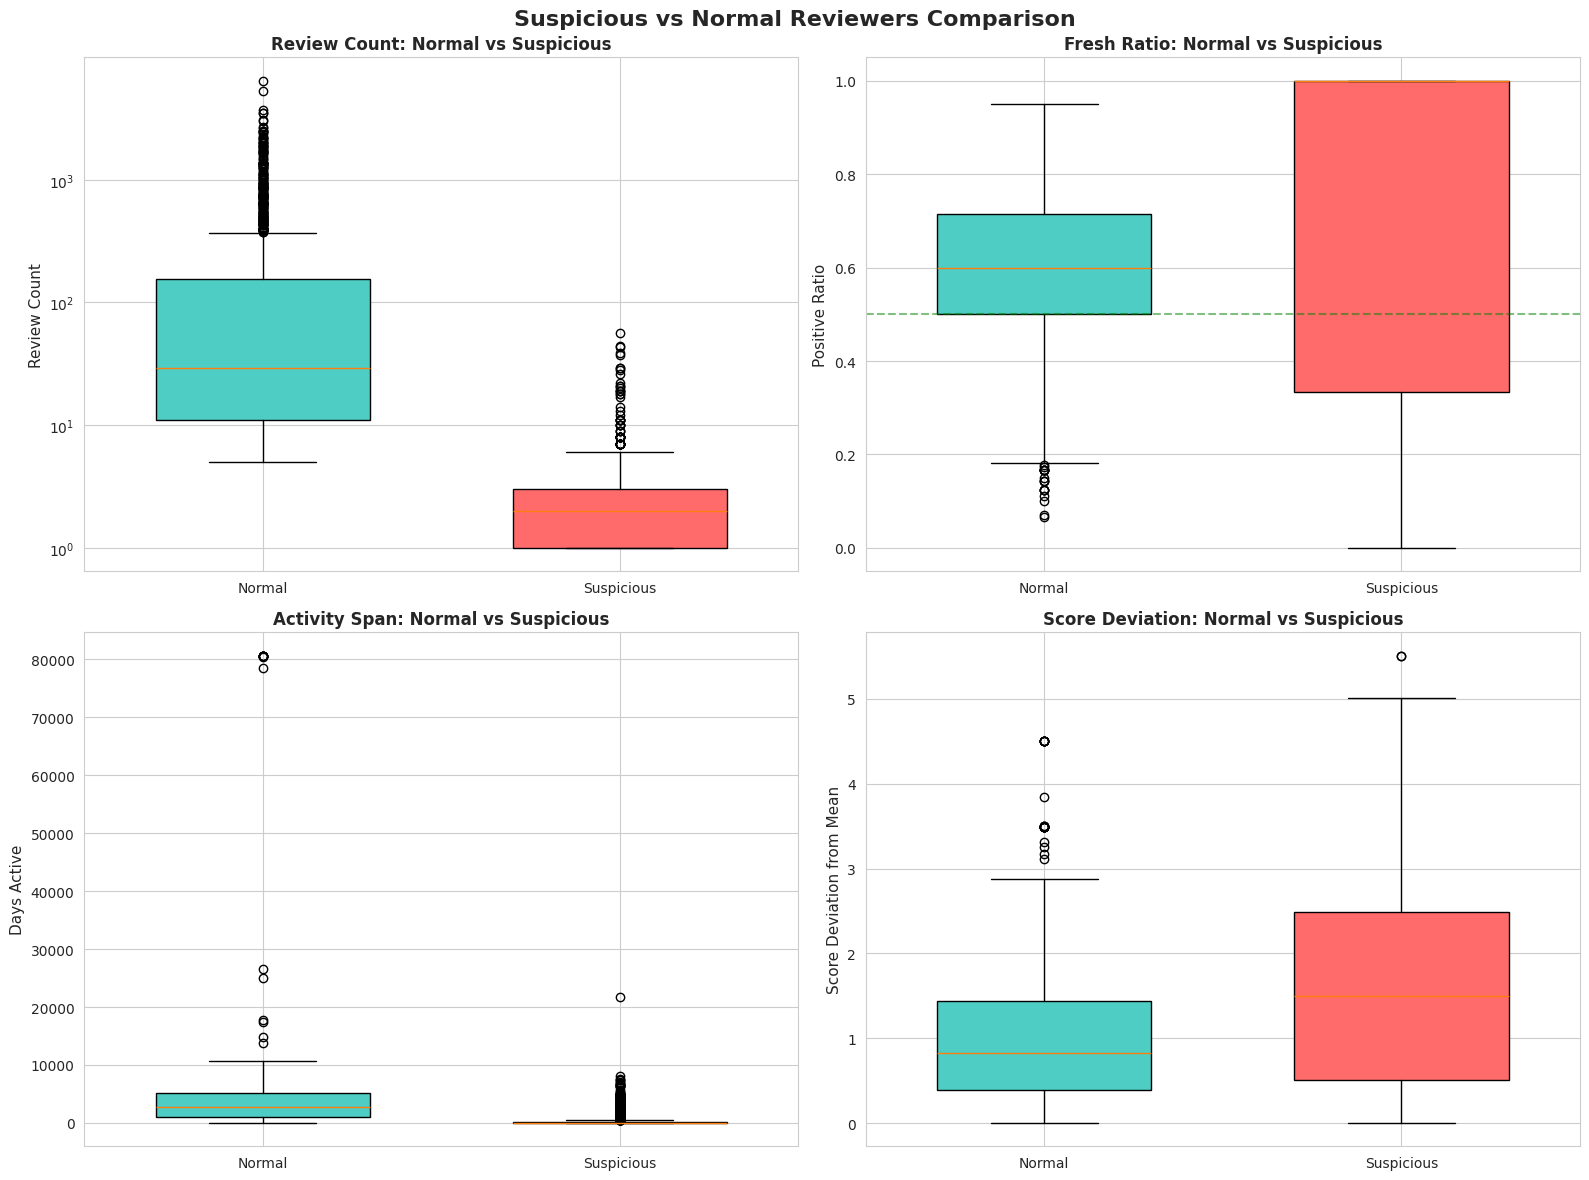

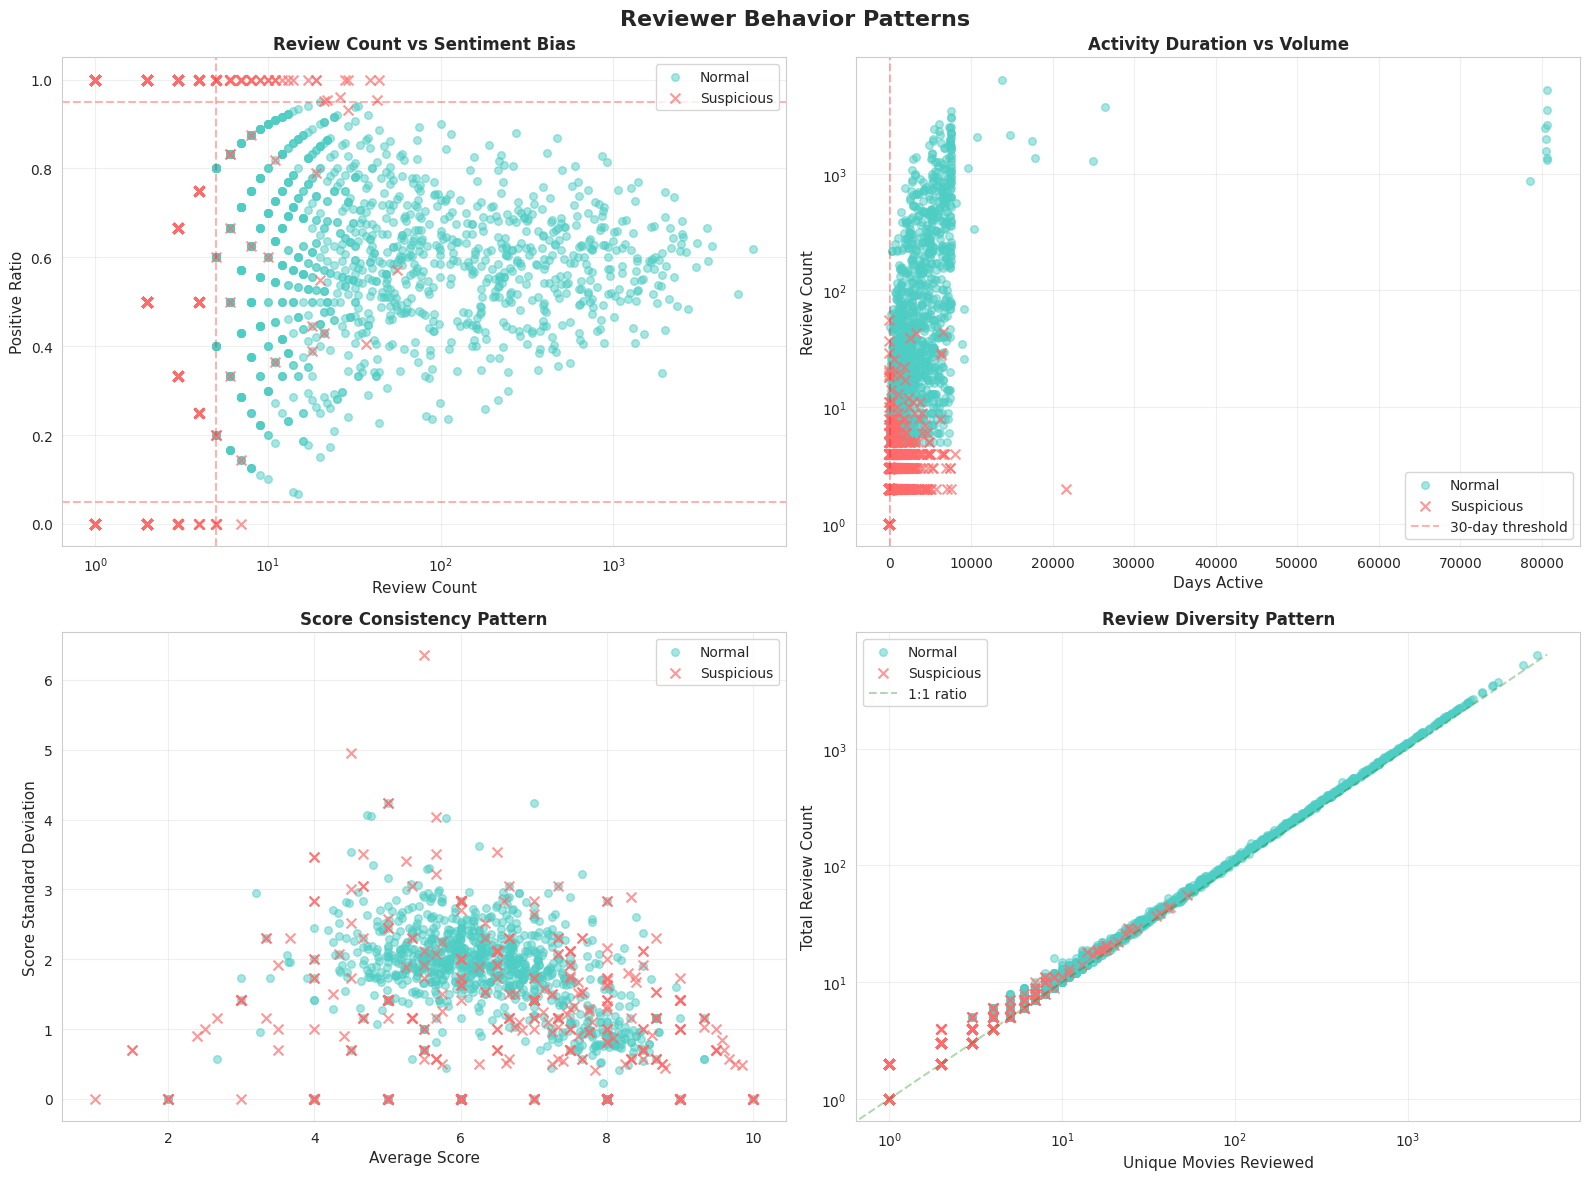

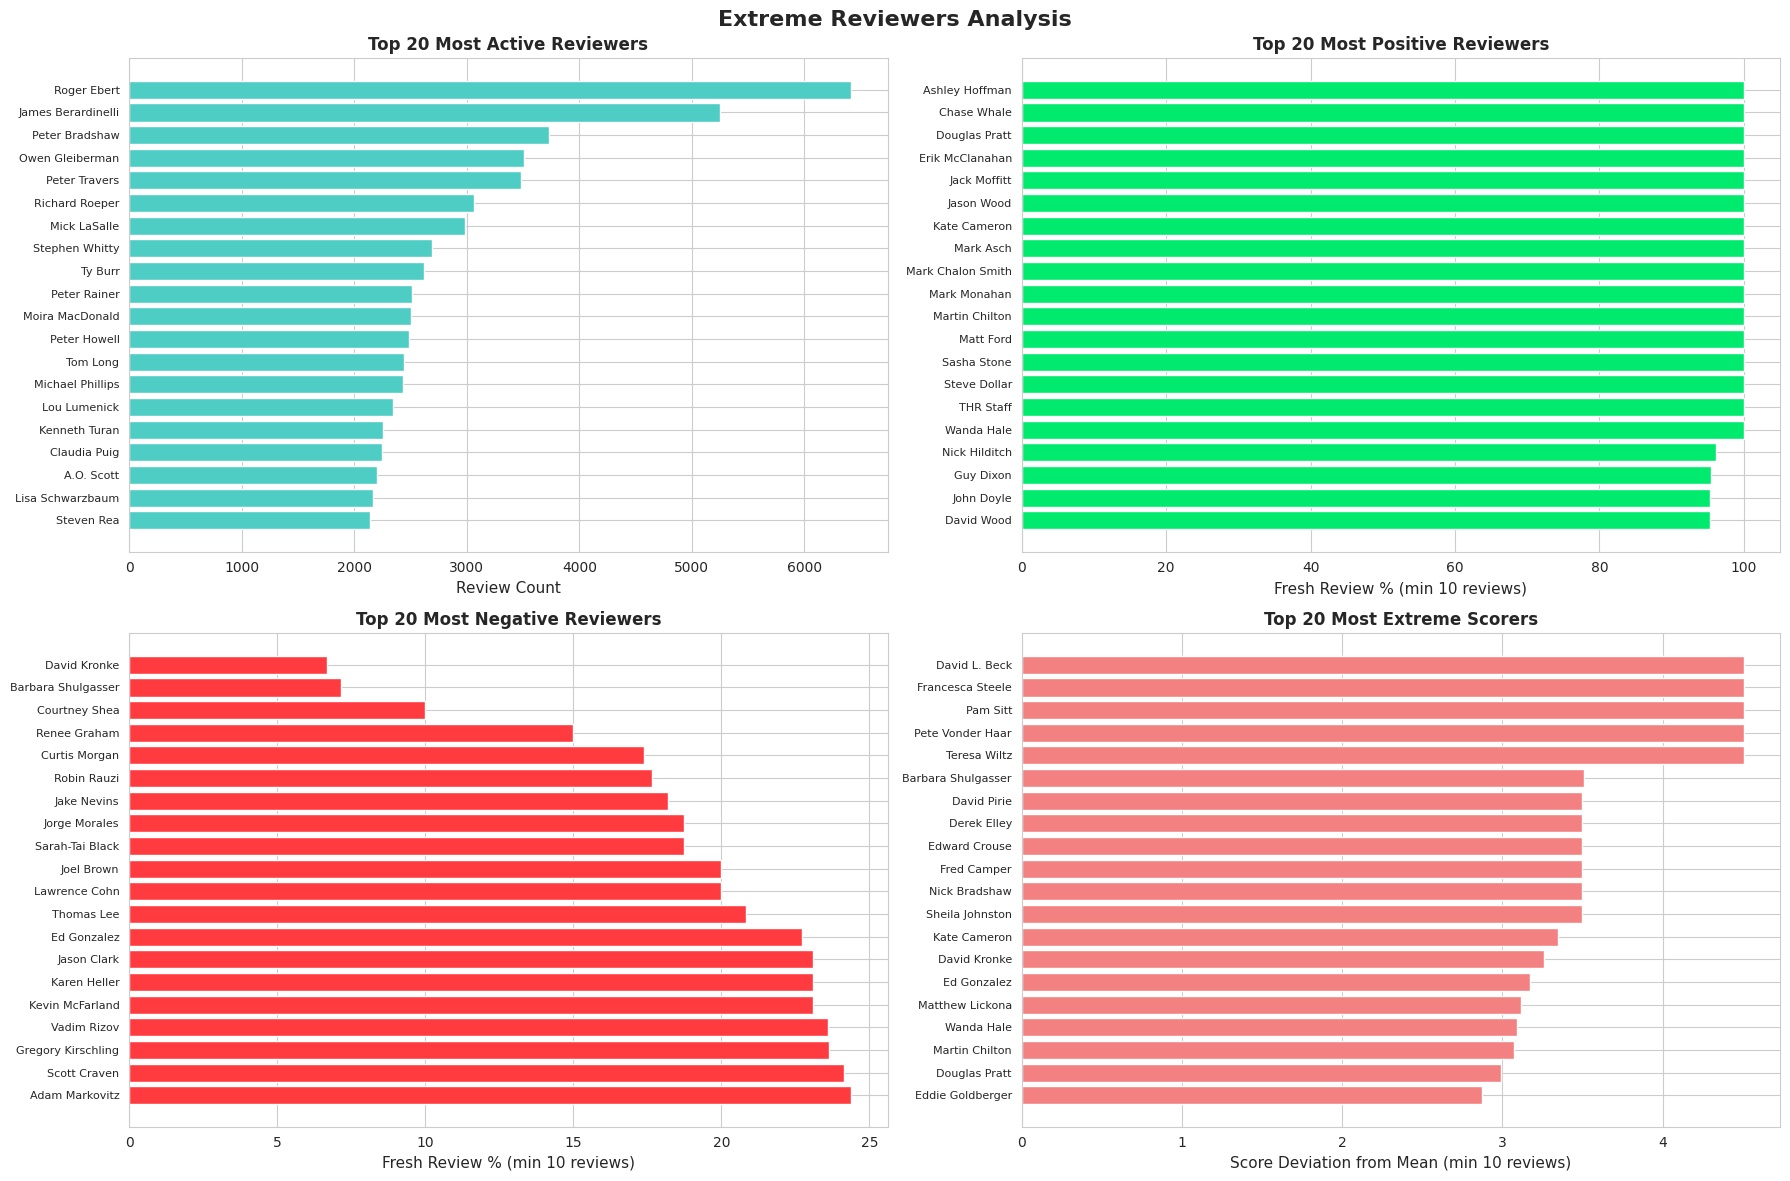


REVIEWER STATISTICS SUMMARY
                Metric All Reviewers Normal  Suspicious
       Total Reviewers          3324   1343        1981
  Suspicious Reviewers  1981 (59.6%)      - 1981 (100%)
Avg Reviews per Critic          85.4  208.0         2.3
        Median Reviews             3     29           2
    Avg Positive Ratio         64.8%  59.8%       68.3%
       Avg Days Active          1727   3692         395
     Avg Unique Movies          76.2  185.7         2.1
   Avg Score Deviation          1.29   0.98        1.59


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ========================================
# SETUP
# ========================================
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# ========================================
# VIZ 1: OVERVIEW - Podstawowe metryki recenzentów
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Reviewer Statistics Overview', fontsize=16, fontweight='bold', y=0.995)

# 1.1 Review count distribution
axes[0, 0].hist(reviewer_stats['review_count'], bins=50, color='#4ECDC4', edgecolor='black')
axes[0, 0].axvline(reviewer_stats['review_count'].median(), color='red',
                   linestyle='--', label=f"Median: {reviewer_stats['review_count'].median():.0f}")
axes[0, 0].set_xlabel('Number of Reviews', fontsize=11)
axes[0, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 0].set_title('Distribution of Review Count per Reviewer', fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()

# 1.2 Positive ratio distribution
axes[0, 1].hist(reviewer_stats['positive_ratio'], bins=30, color='#45B7D1', edgecolor='black')
axes[0, 1].axvline(0.5, color='green', linestyle='--', label='Balanced (50%)')
axes[0, 1].axvline(0.95, color='red', linestyle='--', label='Suspicious (>95%)')
axes[0, 1].axvline(0.05, color='red', linestyle='--', label='Suspicious (<5%)')
axes[0, 1].set_xlabel('Positive Review Ratio', fontsize=11)
axes[0, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 1].set_title('Fresh/Rotten Ratio Distribution', fontweight='bold')
axes[0, 1].legend(fontsize=9)

# 1.3 Days active distribution
axes[0, 2].hist(reviewer_stats['days_active'], bins=50, color='#FF6B6B', edgecolor='black')
axes[0, 2].axvline(30, color='red', linestyle='--', label='Suspicious (<30 days)')
axes[0, 2].set_xlabel('Days Active', fontsize=11)
axes[0, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[0, 2].set_title('Reviewer Activity Span', fontweight='bold')
axes[0, 2].legend()

# 1.4 Average score distribution
axes[1, 0].hist(reviewer_stats['avg_score'].dropna(), bins=30, color='#95E1D3', edgecolor='black')
axes[1, 0].axvline(reviewer_stats['avg_score'].mean(), color='red',
                   linestyle='--', label=f"Mean: {reviewer_stats['avg_score'].mean():.2f}")
axes[1, 0].set_xlabel('Average Score (1-10)', fontsize=11)
axes[1, 0].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 0].set_title('Average Reviewer Score Distribution', fontweight='bold')
axes[1, 0].legend()

# 1.5 Score standard deviation
axes[1, 1].hist(reviewer_stats['score_std'].dropna(), bins=30, color='#F38181', edgecolor='black')
axes[1, 1].set_xlabel('Score Standard Deviation', fontsize=11)
axes[1, 1].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 1].set_title('Score Variability per Reviewer', fontweight='bold')

# 1.6 Unique movies reviewed
axes[1, 2].hist(reviewer_stats['unique_movies'], bins=50, color='#AA96DA', edgecolor='black')
axes[1, 2].set_xlabel('Number of Unique Movies', fontsize=11)
axes[1, 2].set_ylabel('Number of Reviewers', fontsize=11)
axes[1, 2].set_title('Movies Reviewed per Critic', fontweight='bold')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# ========================================
# VIZ 2: SUSPICIOUS vs NORMAL Comparison
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Suspicious vs Normal Reviewers Comparison', fontsize=16, fontweight='bold')

suspicious = reviewer_stats[reviewer_stats['is_suspicious']]
normal = reviewer_stats[~reviewer_stats['is_suspicious']]

print(f"\n📊 Reviewer Classification:")
print(f"   Suspicious reviewers: {len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)")
print(f"   Normal reviewers: {len(normal)} ({len(normal)/len(reviewer_stats)*100:.1f}%)")

# 2.1 Review count comparison
data_to_plot = [normal['review_count'], suspicious['review_count']]
bp1 = axes[0, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp1['boxes'][0].set_facecolor('#4ECDC4')
bp1['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 0].set_ylabel('Review Count', fontsize=11)
axes[0, 0].set_title('Review Count: Normal vs Suspicious', fontweight='bold')
axes[0, 0].set_yscale('log')

# 2.2 Positive ratio comparison
data_to_plot = [normal['positive_ratio'], suspicious['positive_ratio']]
bp2 = axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp2['boxes'][0].set_facecolor('#4ECDC4')
bp2['boxes'][1].set_facecolor('#FF6B6B')
axes[0, 1].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 1].set_title('Fresh Ratio: Normal vs Suspicious', fontweight='bold')
axes[0, 1].axhline(0.5, color='green', linestyle='--', alpha=0.5)

# 2.3 Days active comparison
data_to_plot = [normal['days_active'], suspicious['days_active']]
bp3 = axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp3['boxes'][0].set_facecolor('#4ECDC4')
bp3['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 0].set_ylabel('Days Active', fontsize=11)
axes[1, 0].set_title('Activity Span: Normal vs Suspicious', fontweight='bold')

# 2.4 Score deviation comparison
data_to_plot = [normal['deviation_from_mean'].dropna(), suspicious['deviation_from_mean'].dropna()]
bp4 = axes[1, 1].boxplot(data_to_plot, labels=['Normal', 'Suspicious'],
                          patch_artist=True, widths=0.6)
bp4['boxes'][0].set_facecolor('#4ECDC4')
bp4['boxes'][1].set_facecolor('#FF6B6B')
axes[1, 1].set_ylabel('Score Deviation from Mean', fontsize=11)
axes[1, 1].set_title('Score Deviation: Normal vs Suspicious', fontweight='bold')

plt.tight_layout()
plt.show()

# ========================================
# VIZ 3: SCATTER PLOTS - Relationships
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Reviewer Behavior Patterns', fontsize=16, fontweight='bold')

# 3.1 Review count vs Positive ratio
axes[0, 0].scatter(normal['review_count'], normal['positive_ratio'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 0].scatter(suspicious['review_count'], suspicious['positive_ratio'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 0].axhline(0.95, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axhline(0.05, color='red', linestyle='--', alpha=0.3)
axes[0, 0].axvline(5, color='red', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_ylabel('Positive Ratio', fontsize=11)
axes[0, 0].set_title('Review Count vs Sentiment Bias', fontweight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 3.2 Days active vs Review count
axes[0, 1].scatter(normal['days_active'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[0, 1].scatter(suspicious['days_active'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[0, 1].axvline(30, color='red', linestyle='--', alpha=0.3, label='30-day threshold')
axes[0, 1].set_xlabel('Days Active', fontsize=11)
axes[0, 1].set_ylabel('Review Count', fontsize=11)
axes[0, 1].set_title('Activity Duration vs Volume', fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3.3 Score std vs avg score
axes[1, 0].scatter(normal['avg_score'], normal['score_std'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 0].scatter(suspicious['avg_score'], suspicious['score_std'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
axes[1, 0].set_xlabel('Average Score', fontsize=11)
axes[1, 0].set_ylabel('Score Standard Deviation', fontsize=11)
axes[1, 0].set_title('Score Consistency Pattern', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 3.4 Review count vs unique movies
axes[1, 1].scatter(normal['unique_movies'], normal['review_count'],
                   alpha=0.5, s=30, color='#4ECDC4', label='Normal')
axes[1, 1].scatter(suspicious['unique_movies'], suspicious['review_count'],
                   alpha=0.7, s=50, color='#FF6B6B', marker='x', label='Suspicious')
# Idealna linia: 1 review = 1 movie
max_val = max(reviewer_stats['unique_movies'].max(), reviewer_stats['review_count'].max())
axes[1, 1].plot([0, max_val], [0, max_val], 'g--', alpha=0.3, label='1:1 ratio')
axes[1, 1].set_xlabel('Unique Movies Reviewed', fontsize=11)
axes[1, 1].set_ylabel('Total Review Count', fontsize=11)
axes[1, 1].set_title('Review Diversity Pattern', fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# VIZ 4: TOP/BOTTOM Reviewers
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Extreme Reviewers Analysis', fontsize=16, fontweight='bold')

# 4.1 Top 20 most active reviewers
top_active = reviewer_stats.nlargest(20, 'review_count')
axes[0, 0].barh(range(len(top_active)), top_active['review_count'], color='#4ECDC4')
axes[0, 0].set_yticks(range(len(top_active)))
axes[0, 0].set_yticklabels(top_active['critic_name'], fontsize=8)
axes[0, 0].set_xlabel('Review Count', fontsize=11)
axes[0, 0].set_title('Top 20 Most Active Reviewers', fontweight='bold')
axes[0, 0].invert_yaxis()

# 4.2 Most biased positive
most_positive = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'positive_ratio')
axes[0, 1].barh(range(len(most_positive)), most_positive['positive_ratio']*100, color='#00EA6E')
axes[0, 1].set_yticks(range(len(most_positive)))
axes[0, 1].set_yticklabels(most_positive['critic_name'], fontsize=8)
axes[0, 1].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[0, 1].set_title('Top 20 Most Positive Reviewers', fontweight='bold')
axes[0, 1].invert_yaxis()

# 4.3 Most biased negative
most_negative = reviewer_stats[reviewer_stats['review_count'] >= 10].nsmallest(20, 'positive_ratio')
axes[1, 0].barh(range(len(most_negative)), most_negative['positive_ratio']*100, color='#FF3B3F')
axes[1, 0].set_yticks(range(len(most_negative)))
axes[1, 0].set_yticklabels(most_negative['critic_name'], fontsize=8)
axes[1, 0].set_xlabel('Fresh Review % (min 10 reviews)', fontsize=11)
axes[1, 0].set_title('Top 20 Most Negative Reviewers', fontweight='bold')
axes[1, 0].invert_yaxis()

# 4.4 Highest deviation from mean score
top_deviation = reviewer_stats[reviewer_stats['review_count'] >= 10].nlargest(20, 'deviation_from_mean')
axes[1, 1].barh(range(len(top_deviation)), top_deviation['deviation_from_mean'], color='#F38181')
axes[1, 1].set_yticks(range(len(top_deviation)))
axes[1, 1].set_yticklabels(top_deviation['critic_name'], fontsize=8)
axes[1, 1].set_xlabel('Score Deviation from Mean (min 10 reviews)', fontsize=11)
axes[1, 1].set_title('Top 20 Most Extreme Scorers', fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# ========================================
# VIZ 5: SUMMARY TABLE
# ========================================
print("\n" + "="*80)
print("REVIEWER STATISTICS SUMMARY")
print("="*80)

summary_data = {
    'Metric': ['Total Reviewers', 'Suspicious Reviewers', 'Avg Reviews per Critic',
               'Median Reviews', 'Avg Positive Ratio', 'Avg Days Active',
               'Avg Unique Movies', 'Avg Score Deviation'],
    'All Reviewers': [
        len(reviewer_stats),
        f"{len(suspicious)} ({len(suspicious)/len(reviewer_stats)*100:.1f}%)",
        f"{reviewer_stats['review_count'].mean():.1f}",
        f"{reviewer_stats['review_count'].median():.0f}",
        f"{reviewer_stats['positive_ratio'].mean()*100:.1f}%",
        f"{reviewer_stats['days_active'].mean():.0f}",
        f"{reviewer_stats['unique_movies'].mean():.1f}",
        f"{reviewer_stats['deviation_from_mean'].mean():.2f}"
    ],
    'Normal': [
        len(normal),
        "-",
        f"{normal['review_count'].mean():.1f}",
        f"{normal['review_count'].median():.0f}",
        f"{normal['positive_ratio'].mean()*100:.1f}%",
        f"{normal['days_active'].mean():.0f}",
        f"{normal['unique_movies'].mean():.1f}",
        f"{normal['deviation_from_mean'].mean():.2f}"
    ],
    'Suspicious': [
        len(suspicious),
        f"{len(suspicious)} (100%)",
        f"{suspicious['review_count'].mean():.1f}",
        f"{suspicious['review_count'].median():.0f}",
        f"{suspicious['positive_ratio'].mean()*100:.1f}%",
        f"{suspicious['days_active'].mean():.0f}",
        f"{suspicious['unique_movies'].mean():.1f}",
        f"{suspicious['deviation_from_mean'].mean():.2f}"
    ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


In [49]:
# ========================================
# SUSPICIOUS SCORE: Kompozytowa metryka podejrzliwości recenzenta
# Skala: 1 (najmniej podejrzany) → 10 (najbardziej podejrzany)
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_reviewer_suspicious_score(df):
    """
    Oblicza suspicious_score dla każdego recenzenta (1-10)
    """

    # 1. Agreguj statystyki per recenzent
    reviewer_stats = df.groupby('critic_name').agg({
        'critic_name': 'count',                    # review_count
        'review_type_encoded': 'mean',             # positive_ratio
        'score_10': ['mean', 'std'],               # score stats
        'is_reviewer_burst_24h': 'sum',            # burst count
        'days_since_release': 'mean',              # avg timing
    }).reset_index()

    reviewer_stats.columns = ['critic_name', 'review_count', 'positive_ratio',
                               'score_mean', 'score_std', 'burst_count', 'avg_days_since_release']

    # 2. Oblicz sub-scores (każdy w skali 0-1)

    # a) Burst behavior (0-1)
    # Wysoki burst = podejrzane
    burst_score = np.clip(reviewer_stats['burst_count'] / 5, 0, 1)

    # b) Review velocity (0-1)
    # Bardzo dużo recenzji = podejrzane
    velocity_score = np.clip((reviewer_stats['review_count'] - 10) / 100, 0, 1)

    # c) Bias detection (0-1)
    # Skrajne positive_ratio (blisko 0 lub 1) = podejrzane
    bias_score = np.abs(reviewer_stats['positive_ratio'] - 0.5) * 2

    # d) Score consistency (0-1)
    # Bardzo niskie std = podejrzane (bot-like behavior)
    consistency_score = 1 - np.clip(reviewer_stats['score_std'] / 2.5, 0, 1)

    # e) Early review pattern (0-1)
    # Częste bardzo wczesne recenzje = podejrzane
    early_score = np.clip((7 - reviewer_stats['avg_days_since_release']) / 7, 0, 1)
    early_score = np.maximum(early_score, 0)

    # 3. Weighted composite (wagi do dostrojenia)
    weights = {
        'burst': 0.30,       # Najważniejszy sygnał
        'velocity': 0.15,
        'bias': 0.25,        # Drugi najważniejszy
        'consistency': 0.20,
        'early': 0.10
    }

    suspicious_raw = (
        weights['burst'] * burst_score +
        weights['velocity'] * velocity_score +
        weights['bias'] * bias_score +
        weights['consistency'] * consistency_score +
        weights['early'] * early_score
    )

    # 4. Skaluj do 1-10
    reviewer_stats['suspicious_score'] = 1 + (suspicious_raw * 9)

    # 5. Merge z powrotem do df
    df = df.merge(
        reviewer_stats[['critic_name', 'suspicious_score']],
        on='critic_name',
        how='left'
    )

    return df, reviewer_stats  # ZWRACAMY OBA


# Użycie - ODBIERAMY OBA
df, reviewer_stats = calculate_reviewer_suspicious_score(df)


SUSPICIOUS SCORE ANALYSIS

📊 Suspicious Score Statistics:
count      1439.0
mean      3.61764
std         1.386
min           1.0
25%      2.621393
50%      3.417522
75%      4.644277
max      7.797306
Name: suspicious_score, dtype: Float64

Total reviewers: 3324
Highly suspicious (score > 7): 7 (0.2%)


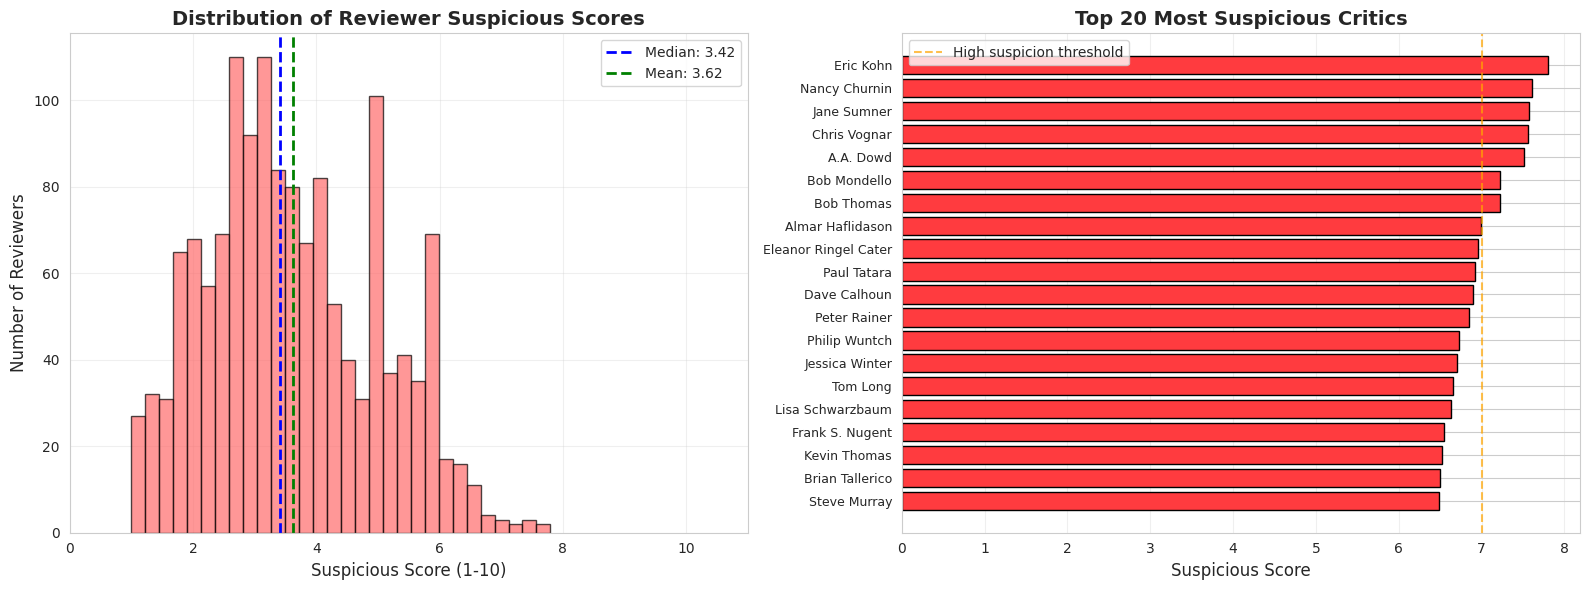


✅ Suspicious score calculation complete!


In [50]:
# ========================================
# WIZUALIZACJA: Histogram + Top 20
# ========================================

print("=" * 60)
print("SUSPICIOUS SCORE ANALYSIS")
print("=" * 60)

# Statystyki
print(f"\n📊 Suspicious Score Statistics:")
print(reviewer_stats['suspicious_score'].describe())
print(f"\nTotal reviewers: {len(reviewer_stats)}")
print(f"Highly suspicious (score > 7): {(reviewer_stats['suspicious_score'] > 7).sum()} ({(reviewer_stats['suspicious_score'] > 7).sum()/len(reviewer_stats)*100:.1f}%)")

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram
axes[0].hist(reviewer_stats['suspicious_score'], bins=30, edgecolor='black',
            color='#FF6B6B', alpha=0.7)
axes[0].axvline(reviewer_stats['suspicious_score'].median(),
               color='blue', linestyle='--', linewidth=2,
               label=f"Median: {reviewer_stats['suspicious_score'].median():.2f}")
axes[0].axvline(reviewer_stats['suspicious_score'].mean(),
               color='green', linestyle='--', linewidth=2,
               label=f"Mean: {reviewer_stats['suspicious_score'].mean():.2f}")
axes[0].set_xlabel('Suspicious Score (1-10)', fontsize=12)
axes[0].set_ylabel('Number of Reviewers', fontsize=12)
axes[0].set_title('Distribution of Reviewer Suspicious Scores',
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 11)

# 2. Top 20 bar chart
top_20_suspicious = reviewer_stats.nlargest(20, 'suspicious_score')
axes[1].barh(range(20), top_20_suspicious['suspicious_score'].values,
            color='#FF3B3F', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_20_suspicious['critic_name'].values, fontsize=9)
axes[1].set_xlabel('Suspicious Score', fontsize=12)
axes[1].set_title('Top 20 Most Suspicious Critics',
                 fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(7, color='orange', linestyle='--', linewidth=1.5,
               alpha=0.7, label='High suspicion threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Suspicious score calculation complete!")


In [51]:
import numpy as np
import pandas as pd

# 1) próg "podejrzanego" recenzenta
SUS_TH = 7.0
# alternatywnie: SUS_TH = df['suspicious_score'].quantile(0.995)

# ROZWIĄZANIE: Obsłuż NA przed konwersją na int
df['is_suspicious_reviewer'] = (
    (df['suspicious_score'] >= SUS_TH)
    .fillna(False)  # Zamień NA na False
    .astype(int)
)

movie_susp = (
    df.groupby('movie_title')
      .agg(
          suspicious_reviews=('is_suspicious_reviewer', 'sum'),
          total_reviews=('is_suspicious_reviewer', 'size'),
          suspicious_ratio=('is_suspicious_reviewer', 'mean'),
          suspicious_reviewers=('critic_name', lambda s: s[df.loc[s.index, 'is_suspicious_reviewer'].eq(1)].nunique())
      )
      .reset_index()
)

MIN_TOTAL = 10  # żeby nie pompować filmów z małą liczbą recenzji
movie_susp = movie_susp[movie_susp['total_reviews'] >= MIN_TOTAL].copy()

movie_susp = movie_susp.sort_values(
    ['suspicious_reviews', 'suspicious_ratio', 'total_reviews'],
    ascending=[False, False, False]
)

movie_susp.head(20)


,movie_title,suspicious_reviews,total_reviews,suspicious_ratio,suspicious_reviewers
9795,Roma,8,112,0.071429,4
10789,Star Wars: Episode VII - The Force Awakens,8,128,0.062500,4
10900,Stories We Tell,6,90,0.066667,3
10582,Son of Saul,6,104,0.057692,3
10605,Sorry to Bother You,6,110,0.054545,3
9497,Ready Player One,6,112,0.053571,3
10669,Spectre,6,112,0.053571,3
10792,Star Wars: The Rise of Skywalker,6,112,0.053571,3
10363,Silver Linings Playbook,6,114,0.052632,3
10777,Star Trek Into Darkness,6,114,0.052632,3


In [52]:
movie_susp_studio = movie_susp.merge(
    movies_df[['movie_title', 'production_company']].drop_duplicates(),
    on='movie_title',
    how='left'
)

movie_susp_studio.head(20)


,movie_title,suspicious_reviews,total_reviews,suspicious_ratio,suspicious_reviewers,production_company
0,Roma,8,112,0.071429,4,Netflix
1,Star Wars: Episode VII - The Force Awakens,8,128,0.062500,4,Walt Disney Pictures
2,Stories We Tell,6,90,0.066667,3,Roadside Attractions
3,Son of Saul,6,104,0.057692,3,Sony Pictures Classics
4,Sorry to Bother You,6,110,0.054545,3,Annapurna Pictures
5,Ready Player One,6,112,0.053571,3,Warner Bros. Pictures
6,Spectre,6,112,0.053571,3,Sony Pictures
7,Star Wars: The Rise of Skywalker,6,112,0.053571,3,Walt Disney Pictures
8,Silver Linings Playbook,6,114,0.052632,3,The Weinstein Company
9,Star Trek Into Darkness,6,114,0.052632,3,Paramount


In [53]:
# A) SUMA podejrzanych recenzji per studio
studio_rank = (
    movie_susp_studio
      .groupby('production_company', dropna=False)
      .agg(
          suspicious_reviews=('suspicious_reviews', 'sum'),
          total_reviews=('total_reviews', 'sum'),
          suspicious_ratio=('suspicious_ratio', 'mean'),   # średnia z filmów (nie ważona)
          movies=('movie_title', 'nunique')
      )
      .reset_index()
      .sort_values(['suspicious_reviews', 'movies'], ascending=[False, False])
)

studio_rank.head(20)

# B) Studia najczęściej występujące w TOP-N filmów
TOP_N = 200
topN = movie_susp_studio.head(TOP_N)

studio_topN = (
    topN.groupby('production_company', dropna=False)
        .agg(
            movies_in_topN=('movie_title', 'nunique'),
            suspicious_reviews_in_topN=('suspicious_reviews', 'sum')
        )
        .reset_index()
        .sort_values(['movies_in_topN', 'suspicious_reviews_in_topN'], ascending=[False, False])
)

studio_topN.head(20)


,production_company,movies_in_topN,suspicious_reviews_in_topN
90,Walt Disney Pictures,11,47
74,Sony Pictures,10,39
75,Sony Pictures Classics,10,35
93,Warner Bros. Pictures,10,33
63,Paramount Pictures,8,26
81,The Weinstein Company,7,28
0,20th Century Fox,7,22
51,Magnolia Pictures,7,20
57,Open Road Films,4,17
56,Netflix,4,15


# MODEL 3 //////////


In [54]:

# ====================================================================================================
# MODEL 3: HYBRID ISOLATION FOREST - FAKE REVIEW DETECTION
# ====================================================================================================
# Unsupervised anomaly detection using numerical features + BERT text embeddings
# Input: DataFrame 'df' z wszystkimi cechami z poprzednich etapów (Model 1, Model 2, EDA)
# Output: fraud_probability (0-100%) + is_fake_review (binary)
# ====================================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("MODEL 3: HYBRID ISOLATION FOREST FOR FAKE REVIEW DETECTION")
print("=" * 100)

# ====================================================================================================
# STEP 1: SELECT & PREPARE NUMERICAL FEATURES
# ====================================================================================================

print("\n🔧 STEP 1: Preparing numerical features...")

# Wybierz features (wszystkie są już w DataFrame z poprzednich kroków)
numerical_features = [
    'reviewer_reviews_last_24h',   # Bot burst detection
    'reviewer_burst_ratio_24h',    # Burst concentration
    'positive_ratio',               # Bias detection
    'score_std',                    # Consistency check
    'days_since_release',           # Timing analysis
    'lexical_diversity',            # Text quality
    'avg_word_length',              # Language complexity
    'word_count',                   # Length check
    'score_residual',               # Model 2 error
    'suspicious_score'              # Composite score
]

# OPTIONAL: Dodaj więcej cech dla lepszych wyników
optional_features = [
    'is_reviewer_burst_any',        # Binary burst flag
    'days_active',                  # Account age
    'unique_movies',                # Spam detection
    'review_count',                 # Volume indicator
    'sentence_count'                # Quality metric
]

# Wybierz: podstawowe albo podstawowe + optional
use_optional = True  # Zmień na False jeśli chcesz tylko 10 podstawowych

if use_optional:
    # Sprawdź które optional features istnieją w df
    available_optional = [f for f in optional_features if f in df.columns]
    all_features = numerical_features + available_optional
    print(f"   Using {len(numerical_features)} base + {len(available_optional)} optional = {len(all_features)} features")
else:
    all_features = numerical_features
    print(f"   Using {len(all_features)} base features only")

# Filtruj DataFrame - usuń wiersze z brakującymi kluczowymi cechami
print("\n📊 Filtering data...")
print(f"   Original size: {len(df):,} reviews")

# Musi mieć text_cleaned i przynajmniej podstawowe numerical features
required_cols = ['text_cleaned'] + numerical_features
df_model3 = df[df[required_cols].notna().all(axis=1)].copy()

print(f"   After filtering: {len(df_model3):,} reviews ({len(df_model3)/len(df)*100:.1f}%)")
print(f"   Removed: {len(df) - len(df_model3):,} reviews with missing data")

# Handle missing values w optional features (jeśli używane)
if use_optional:
    for col in available_optional:
        if df_model3[col].isna().sum() > 0:
            # Fill with median for numerical, 0 for binary
            if df_model3[col].dtype == bool or df_model3[col].nunique() == 2:
                df_model3[col] = df_model3[col].fillna(0).astype(int)
            else:
                df_model3[col] = df_model3[col].fillna(df_model3[col].median())

# Extract numerical features
X_numerical = df_model3[all_features].values

# Standardize (ważne dla IF!)
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

print(f"✅ Numerical features prepared: {X_numerical_scaled.shape}")

MODEL 3: HYBRID ISOLATION FOREST FOR FAKE REVIEW DETECTION

🔧 STEP 1: Preparing numerical features...
   Using 10 base + 5 optional = 15 features

📊 Filtering data...
   Original size: 283,849 reviews
   After filtering: 174,309 reviews (61.4%)
   Removed: 109,540 reviews with missing data
✅ Numerical features prepared: (174309, 15)


In [55]:
# ====================================================================================================
# STEP 2: GENERATE TEXT EMBEDDINGS (BERT)
# ====================================================================================================

print("\n🤖 STEP 2: Generating BERT text embeddings...")
print("   Model: sentence-transformers/all-MiniLM-L6-v2 (384 dims)")
print("   This may take a few minutes for large datasets...")

# Initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode text (batch processing for speed)
text_list = df_model3['text_cleaned'].tolist()

# Progress bar
text_embeddings = model.encode(
    text_list,
    batch_size=64,              # Zwiększ do 128 jeśli masz GPU
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True   # L2 normalization (helps UMAP)
)

print(f"✅ Text embeddings generated: {text_embeddings.shape}")

# ====================================================================================================
# STEP 3: DIMENSIONALITY REDUCTION (UMAP)
# ====================================================================================================

print("\n📉 STEP 3: Reducing text embeddings with UMAP...")
print("   384 dims → 10 dims (preserving semantic structure)")

reducer = umap.UMAP(
    n_components=10,            # Target dimensions
    n_neighbors=15,             # Local structure preservation
    min_dist=0.1,               # Minimum distance in low-dim space
    metric='cosine',            # Best for text embeddings
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

text_embeddings_reduced = reducer.fit_transform(text_embeddings)

print(f"✅ UMAP reduction complete: {text_embeddings_reduced.shape}")

# ====================================================================================================
# STEP 4: COMBINE FEATURES
# ====================================================================================================

print("\n🔗 STEP 4: Combining numerical + text features...")

# Concatenate: [numerical (10-15 dims) + text (10 dims)]
combined_features = np.hstack([
    X_numerical_scaled,         # Scaled numerical
    text_embeddings_reduced     # UMAP-reduced text
])

print(f"✅ Combined feature matrix: {combined_features.shape}")
print(f"   Composition: {X_numerical_scaled.shape[1]} numerical + {text_embeddings_reduced.shape[1]} text")


🤖 STEP 2: Generating BERT text embeddings...
   Model: sentence-transformers/all-MiniLM-L6-v2 (384 dims)
   This may take a few minutes for large datasets...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2724 [00:00<?, ?it/s]

✅ Text embeddings generated: (174309, 384)

📉 STEP 3: Reducing text embeddings with UMAP...
   384 dims → 10 dims (preserving semantic structure)
✅ UMAP reduction complete: (174309, 10)

🔗 STEP 4: Combining numerical + text features...
✅ Combined feature matrix: (174309, 25)
   Composition: 15 numerical + 10 text


In [56]:
# ====================================================================================================
# STEP 5: ISOLATION FOREST TRAINING
# ====================================================================================================

print("\n🌲 STEP 5: Training Isolation Forest...")

# Hyperparameters
contamination = 0.05            # Assume 5% are fake (adjust based on domain knowledge)
n_estimators = 200              # Number of trees (more = more stable)
max_samples = 256               # Subsample size per tree

print(f"   Contamination: {contamination*100:.1f}% (top {contamination*100}% flagged as anomalies)")
print(f"   Estimators: {n_estimators}")
print(f"   Max samples: {max_samples}")

iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators=n_estimators,
    max_samples=max_samples,
    random_state=42,
    n_jobs=-1,                  # Parallel processing
    verbose=0
)

# Fit model
print("   Training...")
iso_forest.fit(combined_features)

# Predict
anomaly_scores = iso_forest.decision_function(combined_features)  # Continuous score
predictions = iso_forest.predict(combined_features)               # -1 = anomaly, 1 = normal

print("✅ Training complete!")

# ====================================================================================================
# STEP 6: PROCESS RESULTS
# ====================================================================================================

print("\n📊 STEP 6: Processing results...")

# Add to DataFrame
df_model3['anomaly_score'] = anomaly_scores
df_model3['is_fake_review'] = (predictions == -1).astype(int)

# Fraud probability (0-100%, normalized)
# Niższy anomaly_score = wyższe fraud probability
min_score = anomaly_scores.min()
max_score = anomaly_scores.max()
df_model3['fraud_probability'] = 100 * (1 - (anomaly_scores - min_score) / (max_score - min_score))

# Statistics
fake_count = df_model3['is_fake_review'].sum()
fake_pct = fake_count / len(df_model3) * 100

print(f"\n✅ Detection complete!")
print(f"   Total reviews analyzed: {len(df_model3):,}")
print(f"   Flagged as fake: {fake_count:,} ({fake_pct:.2f}%)")
print(f"   Legit reviews: {len(df_model3) - fake_count:,} ({100-fake_pct:.2f}%)")


🌲 STEP 5: Training Isolation Forest...
   Contamination: 5.0% (top 5.0% flagged as anomalies)
   Estimators: 200
   Max samples: 256
   Training...
✅ Training complete!

📊 STEP 6: Processing results...

✅ Detection complete!
   Total reviews analyzed: 174,309
   Flagged as fake: 8,716 (5.00%)
   Legit reviews: 165,593 (95.00%)



🔍 STEP 7: Analyzing results...

Top 100 most suspicious reviews:
----------------------------------------------------------------------------------------------------

1. Fraud probability: 100.0%
   Text: all i want for christmas is to never see all i want for christmas again...
   Burst 24h: 2456, Positive ratio: 0.62, Days since release: 2976.0

2. Fraud probability: 98.7%
   Text: it decides that arthur must grow must rise to an occasion must for once take responsibility for his ...
   Burst 24h: 2456, Positive ratio: 0.62, Days since release: 4194.0

3. Fraud probability: 98.5%
   Text: if anybody wondered where lucas has been since the release nearly four years ago of american graffit...
   Burst 24h: 2, Positive ratio: 0.67, Days since release: 14077.0

4. Fraud probability: 98.5%
   Text: if anybody wondered where lucas has been since the release nearly four years ago of american graffit...
   Burst 24h: 2, Positive ratio: 0.67, Days since release: 14077.0

5. Fraud probability

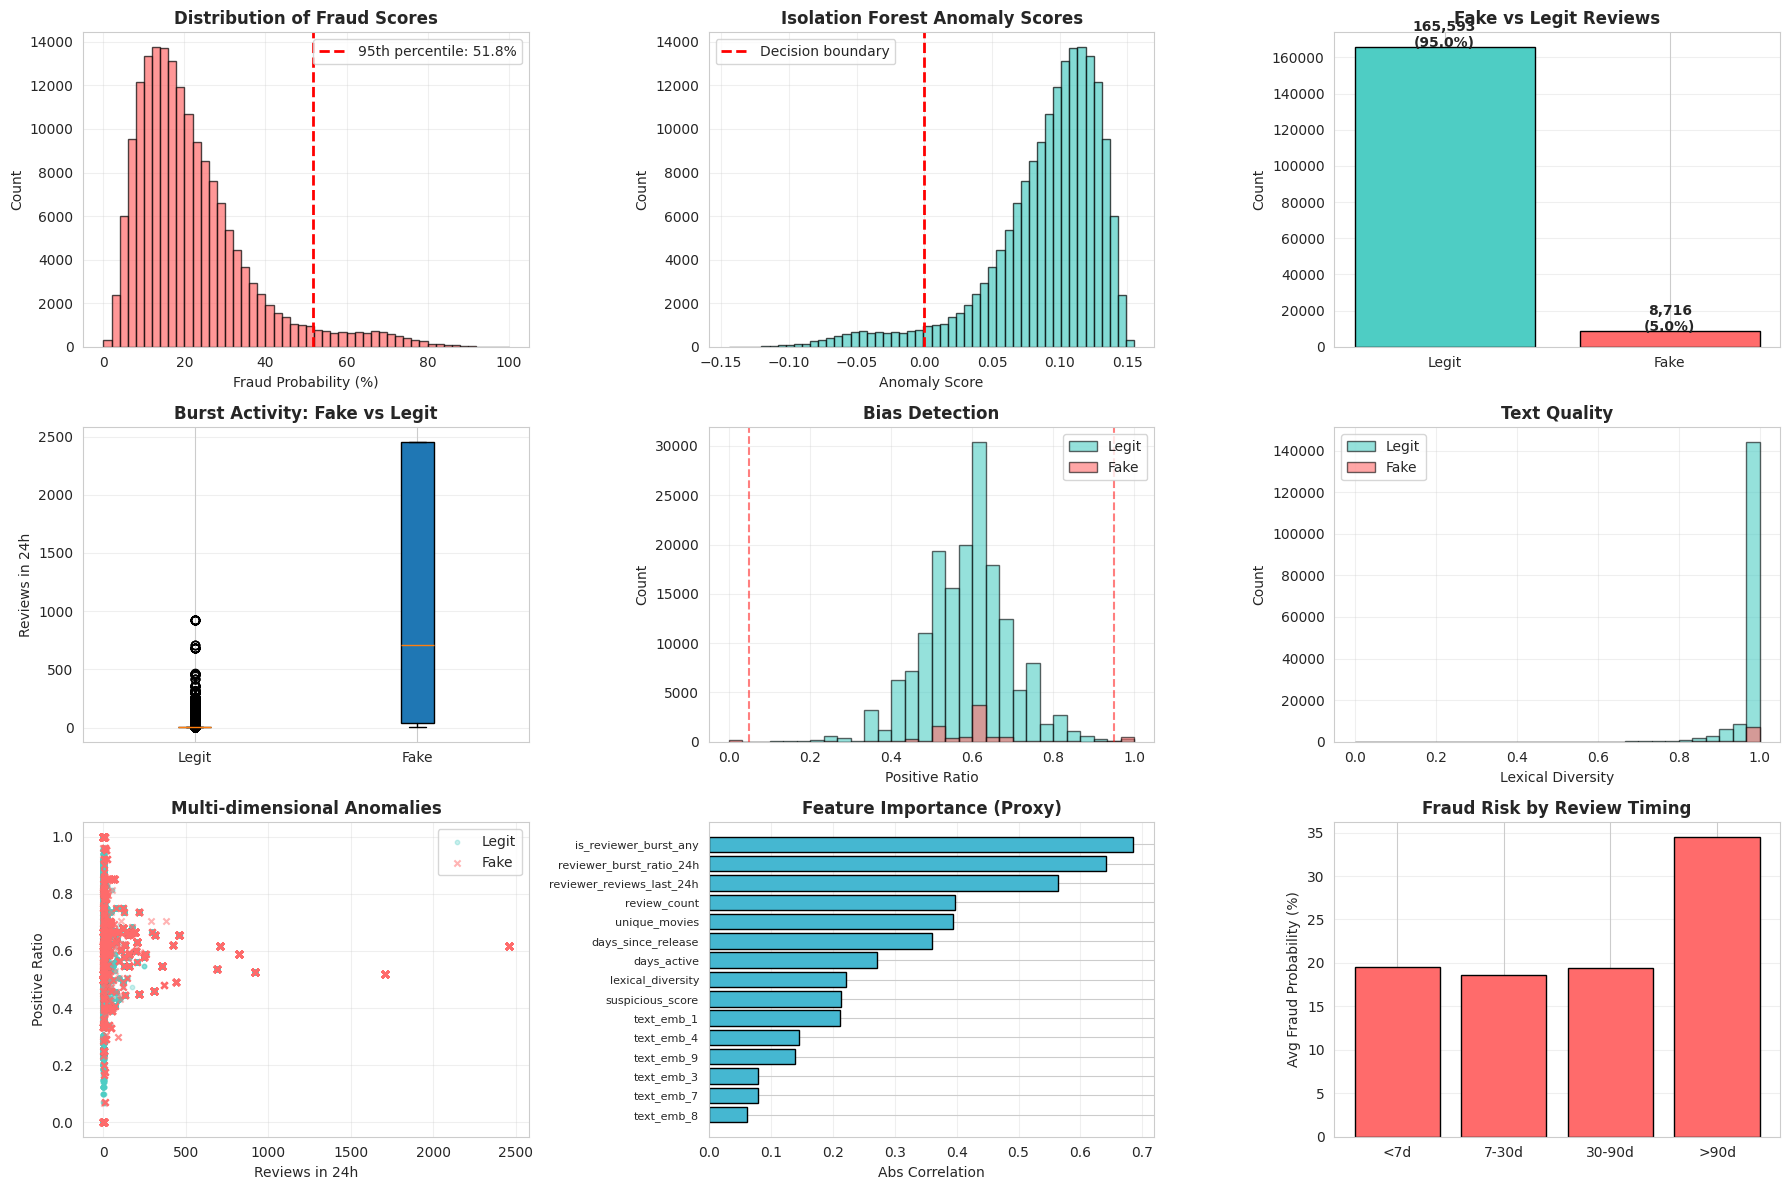


💾 STEP 9: Saving results...
   ✅ Saved: model3_all_results.csv
   ✅ Saved: model3_top_suspicious.csv (top 100)
   ✅ Saved: model3_summary.txt
🎉 HYBRID ISOLATION FOREST MODEL 3 FINISHED SUCCESSFULLY!


In [57]:
# ====================================================================================================
# STEP 7: ANALYSIS & VALIDATION
# ====================================================================================================

print("\n🔍 STEP 7: Analyzing results...")

# Top suspicious reviews
top_n = 100
top_suspicious = df_model3.nlargest(top_n, 'fraud_probability')

print(f"\nTop {top_n} most suspicious reviews:")
print("-" * 100)

# Wyświetl top 10
display_cols = ['fraud_probability', 'reviewer_reviews_last_24h', 'positive_ratio',
                'days_since_release', 'lexical_diversity', 'text_cleaned']
available_display = [col for col in display_cols if col in top_suspicious.columns]

for i, (idx, row) in enumerate(top_suspicious.head(10).iterrows(), 1):
    print(f"\n{i}. Fraud probability: {row['fraud_probability']:.1f}%")
    print(f"   Text: {row['text_cleaned'][:100]}...")
    print(f"   Burst 24h: {row.get('reviewer_reviews_last_24h', 'N/A')}, "
          f"Positive ratio: {row.get('positive_ratio', 'N/A'):.2f}, "
          f"Days since release: {row.get('days_since_release', 'N/A')}")

# Compare fake vs legit
print("\n" + "=" * 100)
print("FEATURE COMPARISON: FAKE vs LEGIT")
print("=" * 100)

fake_df = df_model3[df_model3['is_fake_review'] == 1]
legit_df = df_model3[df_model3['is_fake_review'] == 0]

comparison_features = ['reviewer_reviews_last_24h', 'positive_ratio', 'lexical_diversity',
                       'days_since_release', 'score_std']
available_comparison = [f for f in comparison_features if f in df_model3.columns]

print(f"\n{'Feature':<30} {'Fake (mean)':<15} {'Legit (mean)':<15} {'Difference':<15}")
print("-" * 80)

for feat in available_comparison:
    fake_mean = fake_df[feat].mean()
    legit_mean = legit_df[feat].mean()
    diff = fake_mean - legit_mean
    print(f"{feat:<30} {fake_mean:<15.2f} {legit_mean:<15.2f} {diff:<15.2f}")

# ====================================================================================================
# STEP 8: VISUALIZATIONS
# ====================================================================================================

print("\n📈 STEP 8: Generating visualizations...")

fig = plt.figure(figsize=(18, 12))

# 1. Fraud probability distribution
ax1 = plt.subplot(3, 3, 1)
ax1.hist(df_model3['fraud_probability'], bins=50, edgecolor='black', color='#FF6B6B', alpha=0.7)
threshold_95 = df_model3['fraud_probability'].quantile(0.95)
ax1.axvline(threshold_95, color='red', linestyle='--', linewidth=2,
            label=f'95th percentile: {threshold_95:.1f}%')
ax1.set_xlabel('Fraud Probability (%)', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.set_title('Distribution of Fraud Scores', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Anomaly score distribution
ax2 = plt.subplot(3, 3, 2)
ax2.hist(df_model3['anomaly_score'], bins=50, edgecolor='black', color='#4ECDC4', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Decision boundary')
ax2.set_xlabel('Anomaly Score', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Isolation Forest Anomaly Scores', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Fake vs Legit count
ax3 = plt.subplot(3, 3, 3)
counts = df_model3['is_fake_review'].value_counts()
colors = ['#4ECDC4', '#FF6B6B']
ax3.bar(['Legit', 'Fake'], [counts.get(0, 0), counts.get(1, 0)], color=colors, edgecolor='black')
ax3.set_ylabel('Count', fontsize=10)
ax3.set_title('Fake vs Legit Reviews', fontsize=12, fontweight='bold')
for i, v in enumerate([counts.get(0, 0), counts.get(1, 0)]):
    ax3.text(i, v + 100, f'{v:,}\n({v/len(df_model3)*100:.1f}%)', ha='center', fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Feature comparison: reviewer_reviews_last_24h
if 'reviewer_reviews_last_24h' in df_model3.columns:
    ax4 = plt.subplot(3, 3, 4)
    ax4.boxplot([legit_df['reviewer_reviews_last_24h'], fake_df['reviewer_reviews_last_24h']],
                labels=['Legit', 'Fake'], patch_artist=True)
    ax4.set_ylabel('Reviews in 24h', fontsize=10)
    ax4.set_title('Burst Activity: Fake vs Legit', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')

# 5. Feature comparison: positive_ratio
if 'positive_ratio' in df_model3.columns:
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(legit_df['positive_ratio'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax5.hist(fake_df['positive_ratio'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax5.axvline(0.95, color='red', linestyle='--', alpha=0.5)
    ax5.axvline(0.05, color='red', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Positive Ratio', fontsize=10)
    ax5.set_ylabel('Count', fontsize=10)
    ax5.set_title('Bias Detection', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3)

# 6. Feature comparison: lexical_diversity
if 'lexical_diversity' in df_model3.columns:
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(legit_df['lexical_diversity'], bins=30, alpha=0.6, label='Legit', color='#4ECDC4', edgecolor='black')
    ax6.hist(fake_df['lexical_diversity'], bins=30, alpha=0.6, label='Fake', color='#FF6B6B', edgecolor='black')
    ax6.set_xlabel('Lexical Diversity', fontsize=10)
    ax6.set_ylabel('Count', fontsize=10)
    ax6.set_title('Text Quality', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)

# 7. Scatter: burst vs positive_ratio
if 'reviewer_reviews_last_24h' in df_model3.columns and 'positive_ratio' in df_model3.columns:
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(legit_df['reviewer_reviews_last_24h'], legit_df['positive_ratio'],
                alpha=0.3, s=10, color='#4ECDC4', label='Legit')
    ax7.scatter(fake_df['reviewer_reviews_last_24h'], fake_df['positive_ratio'],
                alpha=0.5, s=20, color='#FF6B6B', marker='x', label='Fake')
    ax7.set_xlabel('Reviews in 24h', fontsize=10)
    ax7.set_ylabel('Positive Ratio', fontsize=10)
    ax7.set_title('Multi-dimensional Anomalies', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(alpha=0.3)

# 8. Feature importance (correlation proxy)
ax8 = plt.subplot(3, 3, 8)
feature_names = all_features + [f'text_emb_{i}' for i in range(10)]
feature_matrix = pd.DataFrame(combined_features, columns=feature_names)
feature_matrix['anomaly_score'] = anomaly_scores
correlations = feature_matrix.corr()['anomaly_score'].drop('anomaly_score').abs().sort_values(ascending=False)
top_corr = correlations.head(15)
ax8.barh(range(len(top_corr)), top_corr.values, color='#45B7D1', edgecolor='black')
ax8.set_yticks(range(len(top_corr)))
ax8.set_yticklabels(top_corr.index, fontsize=8)
ax8.set_xlabel('Abs Correlation', fontsize=10)
ax8.set_title('Feature Importance (Proxy)', fontsize=12, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(alpha=0.3, axis='x')

# 9. Fraud probability by days_since_release
if 'days_since_release' in df_model3.columns:
    ax9 = plt.subplot(3, 3, 9)
    bins = [-np.inf, 7, 30, 90, np.inf]
    labels = ['<7d', '7-30d', '30-90d', '>90d']
    df_model3['release_bin'] = pd.cut(df_model3['days_since_release'], bins=bins, labels=labels)
    fraud_by_timing = df_model3.groupby('release_bin')['fraud_probability'].mean()
    ax9.bar(range(len(fraud_by_timing)), fraud_by_timing.values, color='#FF6B6B', edgecolor='black')
    ax9.set_xticks(range(len(fraud_by_timing)))
    ax9.set_xticklabels(fraud_by_timing.index)
    ax9.set_ylabel('Avg Fraud Probability (%)', fontsize=10)
    ax9.set_title('Fraud Risk by Review Timing', fontsize=12, fontweight='bold')
    ax9.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model3_fake_review_detection_analysis.png', dpi=150, bbox_inches='tight')
print("   ✅ Saved: model3_fake_review_detection_analysis.png")
plt.show()

# ====================================================================================================
# STEP 9: SAVE RESULTS
# ====================================================================================================

print("\n💾 STEP 9: Saving results...")

# Select columns to save
output_cols = [
    'fraud_probability', 'is_fake_review', 'anomaly_score',
    'text_cleaned', 'review_content',
    'reviewer_reviews_last_24h', 'positive_ratio', 'days_since_release',
    'lexical_diversity', 'score_std', 'suspicious_score',
    'movie_title', 'critic_name', 'review_date'
]

# Only keep columns that exist
output_cols_available = [col for col in output_cols if col in df_model3.columns]

# Save all results
df_model3[output_cols_available].to_csv('model3_all_results.csv', index=False, encoding='utf-8')
print("   ✅ Saved: model3_all_results.csv")

# Save top suspicious for manual inspection
top_suspicious[output_cols_available].to_csv('model3_top_suspicious.csv', index=False, encoding='utf-8')
print(f"   ✅ Saved: model3_top_suspicious.csv (top {top_n})")

# Save summary statistics
with open('model3_summary.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 100 + "\n")
    f.write("MODEL 3: HYBRID ISOLATION FOREST - SUMMARY\n")
    f.write("=" * 100 + "\n\n")
    f.write(f"Total reviews analyzed: {len(df_model3):,}\n")
    f.write(f"Flagged as fake: {fake_count:,} ({fake_pct:.2f}%)\n")
    f.write(f"Contamination threshold: {contamination*100}%\n\n")
    f.write("Feature configuration:\n")
    f.write(f"  Numerical features: {len(all_features)}\n")
    f.write(f"  Text embedding dims: 10 (UMAP-reduced from 384)\n")
    f.write(f"  Total dimensions: {combined_features.shape[1]}\n\n")
    f.write("Top features by correlation with anomaly score:\n")
    for i, (feat, corr) in enumerate(correlations.head(10).items(), 1):
        f.write(f"  {i}. {feat}: {corr:.3f}\n")

print("   ✅ Saved: model3_summary.txt")

print("=" * 100)
print("🎉 HYBRID ISOLATION FOREST MODEL 3 FINISHED SUCCESSFULLY!")
print("=" * 100)